In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
5,5,322430009006,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,56,56,1,10.0,16,Pass Completion,Taylor Kelly pass complete to Richard Smith fo...,0.648868,2012,1.087793


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322450030.
[16/5670] Updating 5FR Margin for game_id 322450038...
[16/5670] Updated 5FR Margin for game_id 322450038.
[17/5670] Updating 5FR Margin for game_id 322450057...
[17/5670] Updated 5FR Margin for game_id

[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game_id 322590061.
[97/5670] Updating 5FR Margin for game_id 322590068...
[97/5670] Updated 5FR Margin for game_id 322590068.
[98/5670] Updating 5FR Margin for game_id 322590077...
[98/5670] Updated 5FR Margin for game_id 322590077.
[99/5670] Updating 5FR Margin for game_id 322590084...
[99/5670] Updated 5FR Margin for game_id 322590084.
[100/5670] Updating 5FR Margin for game_id 322590096...
[100/5670] Updated 5FR Margin for game_id 322590096.
[101/5670] Updating 5FR Margin for game_id 322590097...
[101/5670] Updated 5FR Margin for game_id 322590097.
[102/5670] Updating 5FR Margin for game_id 322590120...
[102/5670] Updated 5FR Margin fo

[180/5670] Updated 5FR Margin for game_id 322710264.
[181/5670] Updating 5FR Margin for game_id 322720252...
[181/5670] Updated 5FR Margin for game_id 322720252.
[182/5670] Updating 5FR Margin for game_id 322730005...
[182/5670] Updated 5FR Margin for game_id 322730005.
[183/5670] Updating 5FR Margin for game_id 322730006...
[183/5670] Updated 5FR Margin for game_id 322730006.
[184/5670] Updating 5FR Margin for game_id 322730012...
[184/5670] Updated 5FR Margin for game_id 322730012.
[185/5670] Updating 5FR Margin for game_id 322730025...
[185/5670] Updated 5FR Margin for game_id 322730025.
[186/5670] Updating 5FR Margin for game_id 322730038...
[186/5670] Updated 5FR Margin for game_id 322730038.
[187/5670] Updating 5FR Margin for game_id 322730041...
[187/5670] Updated 5FR Margin for game_id 322730041.
[188/5670] Updating 5FR Margin for game_id 322730058...
[188/5670] Updated 5FR Margin for game_id 322730058.
[189/5670] Updating 5FR Margin for game_id 322730059...
[189/5670] Updated 

[260/5670] Updated 5FR Margin for game_id 322800309.
[261/5670] Updating 5FR Margin for game_id 322800349...
[261/5670] Updated 5FR Margin for game_id 322800349.
[262/5670] Updating 5FR Margin for game_id 322802005...
[262/5670] Updated 5FR Margin for game_id 322802005.
[263/5670] Updating 5FR Margin for game_id 322802006...
[263/5670] Updated 5FR Margin for game_id 322802006.
[264/5670] Updating 5FR Margin for game_id 322802050...
[264/5670] Updated 5FR Margin for game_id 322802050.
[265/5670] Updating 5FR Margin for game_id 322802132...
[265/5670] Updated 5FR Margin for game_id 322802132.
[266/5670] Updating 5FR Margin for game_id 322802199...
[266/5670] Updated 5FR Margin for game_id 322802199.
[267/5670] Updating 5FR Margin for game_id 322802306...
[267/5670] Updated 5FR Margin for game_id 322802306.
[268/5670] Updating 5FR Margin for game_id 322802348...
[268/5670] Updated 5FR Margin for game_id 322802348.
[269/5670] Updating 5FR Margin for game_id 322802393...
[269/5670] Updated 

[340/5670] Updated 5FR Margin for game_id 322940057.
[341/5670] Updating 5FR Margin for game_id 322940059...
[341/5670] Updated 5FR Margin for game_id 322940059.
[342/5670] Updating 5FR Margin for game_id 322940068...
[342/5670] Updated 5FR Margin for game_id 322940068.
[343/5670] Updating 5FR Margin for game_id 322940077...
[343/5670] Updated 5FR Margin for game_id 322940077.
[344/5670] Updating 5FR Margin for game_id 322940087...
[344/5670] Updated 5FR Margin for game_id 322940087.
[345/5670] Updating 5FR Margin for game_id 322940096...
[345/5670] Updated 5FR Margin for game_id 322940096.
[346/5670] Updating 5FR Margin for game_id 322940097...
[346/5670] Updated 5FR Margin for game_id 322940097.
[347/5670] Updating 5FR Margin for game_id 322940098...
[347/5670] Updated 5FR Margin for game_id 322940098.
[348/5670] Updating 5FR Margin for game_id 322940113...
[348/5670] Updated 5FR Margin for game_id 322940113.
[349/5670] Updating 5FR Margin for game_id 322940120...
[349/5670] Updated 

[427/5670] Updated 5FR Margin for game_id 323010349.
[428/5670] Updating 5FR Margin for game_id 323010356...
[428/5670] Updated 5FR Margin for game_id 323010356.
[429/5670] Updating 5FR Margin for game_id 323012084...
[429/5670] Updated 5FR Margin for game_id 323012084.
[430/5670] Updating 5FR Margin for game_id 323012117...
[430/5670] Updated 5FR Margin for game_id 323012117.
[431/5670] Updating 5FR Margin for game_id 323012226...
[431/5670] Updated 5FR Margin for game_id 323012226.
[432/5670] Updating 5FR Margin for game_id 323012229...
[432/5670] Updated 5FR Margin for game_id 323012229.
[433/5670] Updating 5FR Margin for game_id 323012305...
[433/5670] Updated 5FR Margin for game_id 323012305.
[434/5670] Updating 5FR Margin for game_id 323012306...
[434/5670] Updated 5FR Margin for game_id 323012306.
[435/5670] Updating 5FR Margin for game_id 323012393...
[435/5670] Updated 5FR Margin for game_id 323012393.
[436/5670] Updating 5FR Margin for game_id 323012433...
[436/5670] Updated 

[512/5670] Updated 5FR Margin for game_id 323150057.
[513/5670] Updating 5FR Margin for game_id 323150062...
[513/5670] Updated 5FR Margin for game_id 323150062.
[514/5670] Updating 5FR Margin for game_id 323150084...
[514/5670] Updated 5FR Margin for game_id 323150084.
[515/5670] Updating 5FR Margin for game_id 323150098...
[515/5670] Updated 5FR Margin for game_id 323150098.
[516/5670] Updating 5FR Margin for game_id 323150099...
[516/5670] Updated 5FR Margin for game_id 323150099.
[517/5670] Updating 5FR Margin for game_id 323150103...
[517/5670] Updated 5FR Margin for game_id 323150103.
[518/5670] Updating 5FR Margin for game_id 323150130...
[518/5670] Updated 5FR Margin for game_id 323150130.
[519/5670] Updating 5FR Margin for game_id 323150145...
[519/5670] Updated 5FR Margin for game_id 323150145.
[520/5670] Updating 5FR Margin for game_id 323150152...
[520/5670] Updated 5FR Margin for game_id 323150152.
[521/5670] Updating 5FR Margin for game_id 323150153...
[521/5670] Updated 

[590/5670] Updated 5FR Margin for game_id 323220344.
[591/5670] Updating 5FR Margin for game_id 323220349...
[591/5670] Updated 5FR Margin for game_id 323220349.
[592/5670] Updating 5FR Margin for game_id 323220356...
[592/5670] Updated 5FR Margin for game_id 323220356.
[593/5670] Updating 5FR Margin for game_id 323222117...
[593/5670] Updated 5FR Margin for game_id 323222117.
[594/5670] Updating 5FR Margin for game_id 323222132...
[594/5670] Updated 5FR Margin for game_id 323222132.
[595/5670] Updating 5FR Margin for game_id 323222305...
[595/5670] Updated 5FR Margin for game_id 323222305.
[596/5670] Updating 5FR Margin for game_id 323222348...
[596/5670] Updated 5FR Margin for game_id 323222348.
[597/5670] Updating 5FR Margin for game_id 323222390...
[597/5670] Updated 5FR Margin for game_id 323222390.
[598/5670] Updating 5FR Margin for game_id 323222426...
[598/5670] Updated 5FR Margin for game_id 323222426.
[599/5670] Updating 5FR Margin for game_id 323222433...
[599/5670] Updated 

[668/5670] Updated 5FR Margin for game_id 323360061.
[669/5670] Updating 5FR Margin for game_id 323360062...
[669/5670] Updated 5FR Margin for game_id 323360062.
[670/5670] Updating 5FR Margin for game_id 323360202...
[670/5670] Updated 5FR Margin for game_id 323360202.
[671/5670] Updating 5FR Margin for game_id 323360239...
[671/5670] Updated 5FR Margin for game_id 323360239.
[672/5670] Updating 5FR Margin for game_id 323360275...
[672/5670] Updated 5FR Margin for game_id 323360275.
[673/5670] Updating 5FR Margin for game_id 323360277...
[673/5670] Updated 5FR Margin for game_id 323360277.
[674/5670] Updating 5FR Margin for game_id 323360326...
[674/5670] Updated 5FR Margin for game_id 323360326.
[675/5670] Updating 5FR Margin for game_id 323362032...
[675/5670] Updated 5FR Margin for game_id 323362032.
[676/5670] Updating 5FR Margin for game_id 323362226...
[676/5670] Updated 5FR Margin for game_id 323362226.
[677/5670] Updating 5FR Margin for game_id 323362306...
[677/5670] Updated 

[748/5670] Updated 5FR Margin for game_id 332500204.
[749/5670] Updating 5FR Margin for game_id 332500213...
[749/5670] Updated 5FR Margin for game_id 332500213.
[750/5670] Updating 5FR Margin for game_id 332500218...
[750/5670] Updated 5FR Margin for game_id 332500218.
[751/5670] Updating 5FR Margin for game_id 332500235...
[751/5670] Updated 5FR Margin for game_id 332500235.
[752/5670] Updating 5FR Margin for game_id 332500239...
[752/5670] Updated 5FR Margin for game_id 332500239.
[753/5670] Updating 5FR Margin for game_id 332500252...
[753/5670] Updated 5FR Margin for game_id 332500252.
[754/5670] Updating 5FR Margin for game_id 332500258...
[754/5670] Updated 5FR Margin for game_id 332500258.
[755/5670] Updating 5FR Margin for game_id 332500356...
[755/5670] Updated 5FR Margin for game_id 332500356.
[756/5670] Updating 5FR Margin for game_id 332502005...
[756/5670] Updated 5FR Margin for game_id 332502005.
[757/5670] Updating 5FR Margin for game_id 332502050...
[757/5670] Updated 

[830/5670] Updated 5FR Margin for game_id 332640193.
[831/5670] Updating 5FR Margin for game_id 332640213...
[831/5670] Updated 5FR Margin for game_id 332640213.
[832/5670] Updating 5FR Margin for game_id 332640235...
[832/5670] Updated 5FR Margin for game_id 332640235.
[833/5670] Updating 5FR Margin for game_id 332640239...
[833/5670] Updated 5FR Margin for game_id 332640239.
[834/5670] Updating 5FR Margin for game_id 332640242...
[834/5670] Updated 5FR Margin for game_id 332640242.
[835/5670] Updating 5FR Margin for game_id 332640245...
[835/5670] Updated 5FR Margin for game_id 332640245.
[836/5670] Updating 5FR Margin for game_id 332640251...
[836/5670] Updated 5FR Margin for game_id 332640251.
[837/5670] Updating 5FR Margin for game_id 332640252...
[837/5670] Updated 5FR Margin for game_id 332640252.
[838/5670] Updating 5FR Margin for game_id 332640259...
[838/5670] Updated 5FR Margin for game_id 332640259.
[839/5670] Updating 5FR Margin for game_id 332640275...
[839/5670] Updated 

[906/5670] Updated 5FR Margin for game_id 332780005.
[907/5670] Updating 5FR Margin for game_id 332780024...
[907/5670] Updated 5FR Margin for game_id 332780024.
[908/5670] Updating 5FR Margin for game_id 332780025...
[908/5670] Updated 5FR Margin for game_id 332780025.
[909/5670] Updating 5FR Margin for game_id 332780038...
[909/5670] Updated 5FR Margin for game_id 332780038.
[910/5670] Updating 5FR Margin for game_id 332780052...
[910/5670] Updated 5FR Margin for game_id 332780052.
[911/5670] Updating 5FR Margin for game_id 332780057...
[911/5670] Updated 5FR Margin for game_id 332780057.
[912/5670] Updating 5FR Margin for game_id 332780058...
[912/5670] Updated 5FR Margin for game_id 332780058.
[913/5670] Updating 5FR Margin for game_id 332780062...
[913/5670] Updated 5FR Margin for game_id 332780062.
[914/5670] Updating 5FR Margin for game_id 332780077...
[914/5670] Updated 5FR Margin for game_id 332780077.
[915/5670] Updating 5FR Margin for game_id 332780084...
[915/5670] Updated 

[983/5670] Updated 5FR Margin for game_id 332850265.
[984/5670] Updating 5FR Margin for game_id 332850275...
[984/5670] Updated 5FR Margin for game_id 332850275.
[985/5670] Updating 5FR Margin for game_id 332850326...
[985/5670] Updated 5FR Margin for game_id 332850326.
[986/5670] Updating 5FR Margin for game_id 332850328...
[986/5670] Updated 5FR Margin for game_id 332850328.
[987/5670] Updating 5FR Margin for game_id 332850344...
[987/5670] Updated 5FR Margin for game_id 332850344.
[988/5670] Updating 5FR Margin for game_id 332850349...
[988/5670] Updated 5FR Margin for game_id 332850349.
[989/5670] Updating 5FR Margin for game_id 332852050...
[989/5670] Updated 5FR Margin for game_id 332852050.
[990/5670] Updating 5FR Margin for game_id 332852226...
[990/5670] Updated 5FR Margin for game_id 332852226.
[991/5670] Updating 5FR Margin for game_id 332852229...
[991/5670] Updated 5FR Margin for game_id 332852229.
[992/5670] Updating 5FR Margin for game_id 332852247...
[992/5670] Updated 

[1058/5670] Updated 5FR Margin for game_id 332990023.
[1059/5670] Updating 5FR Margin for game_id 332990030...
[1059/5670] Updated 5FR Margin for game_id 332990030.
[1060/5670] Updating 5FR Margin for game_id 332990038...
[1060/5670] Updated 5FR Margin for game_id 332990038.
[1061/5670] Updating 5FR Margin for game_id 332990052...
[1061/5670] Updated 5FR Margin for game_id 332990052.
[1062/5670] Updating 5FR Margin for game_id 332990058...
[1062/5670] Updated 5FR Margin for game_id 332990058.
[1063/5670] Updating 5FR Margin for game_id 332990062...
[1063/5670] Updated 5FR Margin for game_id 332990062.
[1064/5670] Updating 5FR Margin for game_id 332990066...
[1064/5670] Updated 5FR Margin for game_id 332990066.
[1065/5670] Updating 5FR Margin for game_id 332990098...
[1065/5670] Updated 5FR Margin for game_id 332990098.
[1066/5670] Updating 5FR Margin for game_id 332990113...
[1066/5670] Updated 5FR Margin for game_id 332990113.
[1067/5670] Updating 5FR Margin for game_id 332990120...
[

[1139/5670] Updated 5FR Margin for game_id 333062005.
[1140/5670] Updating 5FR Margin for game_id 333062006...
[1140/5670] Updated 5FR Margin for game_id 333062006.
[1141/5670] Updating 5FR Margin for game_id 333062226...
[1141/5670] Updated 5FR Margin for game_id 333062226.
[1142/5670] Updating 5FR Margin for game_id 333062229...
[1142/5670] Updated 5FR Margin for game_id 333062229.
[1143/5670] Updating 5FR Margin for game_id 333062247...
[1143/5670] Updated 5FR Margin for game_id 333062247.
[1144/5670] Updating 5FR Margin for game_id 333062294...
[1144/5670] Updated 5FR Margin for game_id 333062294.
[1145/5670] Updating 5FR Margin for game_id 333062306...
[1145/5670] Updated 5FR Margin for game_id 333062306.
[1146/5670] Updating 5FR Margin for game_id 333062439...
[1146/5670] Updated 5FR Margin for game_id 333062439.
[1147/5670] Updating 5FR Margin for game_id 333062509...
[1147/5670] Updated 5FR Margin for game_id 333062509.
[1148/5670] Updating 5FR Margin for game_id 333062579...
[

[1217/5670] Updated 5FR Margin for game_id 333200062.
[1218/5670] Updating 5FR Margin for game_id 333200068...
[1218/5670] Updated 5FR Margin for game_id 333200068.
[1219/5670] Updating 5FR Margin for game_id 333200077...
[1219/5670] Updated 5FR Margin for game_id 333200077.
[1220/5670] Updating 5FR Margin for game_id 333200097...
[1220/5670] Updated 5FR Margin for game_id 333200097.
[1221/5670] Updating 5FR Margin for game_id 333200103...
[1221/5670] Updated 5FR Margin for game_id 333200103.
[1222/5670] Updating 5FR Margin for game_id 333200113...
[1222/5670] Updated 5FR Margin for game_id 333200113.
[1223/5670] Updating 5FR Margin for game_id 333200145...
[1223/5670] Updated 5FR Margin for game_id 333200145.
[1224/5670] Updating 5FR Margin for game_id 333200150...
[1224/5670] Updated 5FR Margin for game_id 333200150.
[1225/5670] Updating 5FR Margin for game_id 333200151...
[1225/5670] Updated 5FR Margin for game_id 333200151.
[1226/5670] Updating 5FR Margin for game_id 333200158...
[

[1299/5670] Updated 5FR Margin for game_id 333272306.
[1300/5670] Updating 5FR Margin for game_id 333272348...
[1300/5670] Updated 5FR Margin for game_id 333272348.
[1301/5670] Updating 5FR Margin for game_id 333272390...
[1301/5670] Updated 5FR Margin for game_id 333272390.
[1302/5670] Updating 5FR Margin for game_id 333272509...
[1302/5670] Updated 5FR Margin for game_id 333272509.
[1303/5670] Updating 5FR Margin for game_id 333272572...
[1303/5670] Updated 5FR Margin for game_id 333272572.
[1304/5670] Updating 5FR Margin for game_id 333272579...
[1304/5670] Updated 5FR Margin for game_id 333272579.
[1305/5670] Updating 5FR Margin for game_id 333272633...
[1305/5670] Updated 5FR Margin for game_id 333272633.
[1306/5670] Updating 5FR Margin for game_id 333272655...
[1306/5670] Updated 5FR Margin for game_id 333272655.
[1307/5670] Updating 5FR Margin for game_id 333272751...
[1307/5670] Updated 5FR Margin for game_id 333272751.
[1308/5670] Updating 5FR Margin for game_id 333302459...
[

[1382/5670] Updated 5FR Margin for game_id 400547641.
[1383/5670] Updating 5FR Margin for game_id 400547642...
[1383/5670] Updated 5FR Margin for game_id 400547642.
[1384/5670] Updating 5FR Margin for game_id 400547644...
[1384/5670] Updated 5FR Margin for game_id 400547644.
[1385/5670] Updating 5FR Margin for game_id 400547647...
[1385/5670] Updated 5FR Margin for game_id 400547647.
[1386/5670] Updating 5FR Margin for game_id 400547648...
[1386/5670] Updated 5FR Margin for game_id 400547648.
[1387/5670] Updating 5FR Margin for game_id 400547650...
[1387/5670] Updated 5FR Margin for game_id 400547650.
[1388/5670] Updating 5FR Margin for game_id 400547652...
[1388/5670] Updated 5FR Margin for game_id 400547652.
[1389/5670] Updating 5FR Margin for game_id 400547653...
[1389/5670] Updated 5FR Margin for game_id 400547653.
[1390/5670] Updating 5FR Margin for game_id 400547654...
[1390/5670] Updated 5FR Margin for game_id 400547654.
[1391/5670] Updating 5FR Margin for game_id 400547655...
[

[1460/5670] Updated 5FR Margin for game_id 400547730.
[1461/5670] Updating 5FR Margin for game_id 400547732...
[1461/5670] Updated 5FR Margin for game_id 400547732.
[1462/5670] Updating 5FR Margin for game_id 400547733...
[1462/5670] Updated 5FR Margin for game_id 400547733.
[1463/5670] Updating 5FR Margin for game_id 400547734...
[1463/5670] Updated 5FR Margin for game_id 400547734.
[1464/5670] Updating 5FR Margin for game_id 400547735...
[1464/5670] Updated 5FR Margin for game_id 400547735.
[1465/5670] Updating 5FR Margin for game_id 400547736...
[1465/5670] Updated 5FR Margin for game_id 400547736.
[1466/5670] Updating 5FR Margin for game_id 400547737...
[1466/5670] Updated 5FR Margin for game_id 400547737.
[1467/5670] Updating 5FR Margin for game_id 400547738...
[1467/5670] Updated 5FR Margin for game_id 400547738.
[1468/5670] Updating 5FR Margin for game_id 400547739...
[1468/5670] Updated 5FR Margin for game_id 400547739.
[1469/5670] Updating 5FR Margin for game_id 400547740...
[

[1538/5670] Updated 5FR Margin for game_id 400547819.
[1539/5670] Updating 5FR Margin for game_id 400547820...
[1539/5670] Updated 5FR Margin for game_id 400547820.
[1540/5670] Updating 5FR Margin for game_id 400547822...
[1540/5670] Updated 5FR Margin for game_id 400547822.
[1541/5670] Updating 5FR Margin for game_id 400547823...
[1541/5670] Updated 5FR Margin for game_id 400547823.
[1542/5670] Updating 5FR Margin for game_id 400547824...
[1542/5670] Updated 5FR Margin for game_id 400547824.
[1543/5670] Updating 5FR Margin for game_id 400547826...
[1543/5670] Updated 5FR Margin for game_id 400547826.
[1544/5670] Updating 5FR Margin for game_id 400547827...
[1544/5670] Updated 5FR Margin for game_id 400547827.
[1545/5670] Updating 5FR Margin for game_id 400547828...
[1545/5670] Updated 5FR Margin for game_id 400547828.
[1546/5670] Updating 5FR Margin for game_id 400547829...
[1546/5670] Updated 5FR Margin for game_id 400547829.
[1547/5670] Updating 5FR Margin for game_id 400547831...
[

[1617/5670] Updated 5FR Margin for game_id 400547911.
[1618/5670] Updating 5FR Margin for game_id 400547912...
[1618/5670] Updated 5FR Margin for game_id 400547912.
[1619/5670] Updating 5FR Margin for game_id 400547913...
[1619/5670] Updated 5FR Margin for game_id 400547913.
[1620/5670] Updating 5FR Margin for game_id 400547914...
[1620/5670] Updated 5FR Margin for game_id 400547914.
[1621/5670] Updating 5FR Margin for game_id 400547915...
[1621/5670] Updated 5FR Margin for game_id 400547915.
[1622/5670] Updating 5FR Margin for game_id 400547917...
[1622/5670] Updated 5FR Margin for game_id 400547917.
[1623/5670] Updating 5FR Margin for game_id 400547918...
[1623/5670] Updated 5FR Margin for game_id 400547918.
[1624/5670] Updating 5FR Margin for game_id 400547920...
[1624/5670] Updated 5FR Margin for game_id 400547920.
[1625/5670] Updating 5FR Margin for game_id 400547921...
[1625/5670] Updated 5FR Margin for game_id 400547921.
[1626/5670] Updating 5FR Margin for game_id 400547922...
[

[1693/5670] Updated 5FR Margin for game_id 400547997.
[1694/5670] Updating 5FR Margin for game_id 400547998...
[1694/5670] Updated 5FR Margin for game_id 400547998.
[1695/5670] Updating 5FR Margin for game_id 400547999...
[1695/5670] Updated 5FR Margin for game_id 400547999.
[1696/5670] Updating 5FR Margin for game_id 400548000...
[1696/5670] Updated 5FR Margin for game_id 400548000.
[1697/5670] Updating 5FR Margin for game_id 400548002...
[1697/5670] Updated 5FR Margin for game_id 400548002.
[1698/5670] Updating 5FR Margin for game_id 400548003...
[1698/5670] Updated 5FR Margin for game_id 400548003.
[1699/5670] Updating 5FR Margin for game_id 400548005...
[1699/5670] Updated 5FR Margin for game_id 400548005.
[1700/5670] Updating 5FR Margin for game_id 400548008...
[1700/5670] Updated 5FR Margin for game_id 400548008.
[1701/5670] Updating 5FR Margin for game_id 400548009...
[1701/5670] Updated 5FR Margin for game_id 400548009.
[1702/5670] Updating 5FR Margin for game_id 400548010...
[

[1775/5670] Updated 5FR Margin for game_id 400548102.
[1776/5670] Updating 5FR Margin for game_id 400548103...
[1776/5670] Updated 5FR Margin for game_id 400548103.
[1777/5670] Updating 5FR Margin for game_id 400548104...
[1777/5670] Updated 5FR Margin for game_id 400548104.
[1778/5670] Updating 5FR Margin for game_id 400548106...
[1778/5670] Updated 5FR Margin for game_id 400548106.
[1779/5670] Updating 5FR Margin for game_id 400548108...
[1779/5670] Updated 5FR Margin for game_id 400548108.
[1780/5670] Updating 5FR Margin for game_id 400548109...
[1780/5670] Updated 5FR Margin for game_id 400548109.
[1781/5670] Updating 5FR Margin for game_id 400548111...
[1781/5670] Updated 5FR Margin for game_id 400548111.
[1782/5670] Updating 5FR Margin for game_id 400548115...
[1782/5670] Updated 5FR Margin for game_id 400548115.
[1783/5670] Updating 5FR Margin for game_id 400548116...
[1783/5670] Updated 5FR Margin for game_id 400548116.
[1784/5670] Updating 5FR Margin for game_id 400548117...
[

[1851/5670] Updated 5FR Margin for game_id 400548199.
[1852/5670] Updating 5FR Margin for game_id 400548200...
[1852/5670] Updated 5FR Margin for game_id 400548200.
[1853/5670] Updating 5FR Margin for game_id 400548201...
[1853/5670] Updated 5FR Margin for game_id 400548201.
[1854/5670] Updating 5FR Margin for game_id 400548202...
[1854/5670] Updated 5FR Margin for game_id 400548202.
[1855/5670] Updating 5FR Margin for game_id 400548203...
[1855/5670] Updated 5FR Margin for game_id 400548203.
[1856/5670] Updating 5FR Margin for game_id 400548204...
[1856/5670] Updated 5FR Margin for game_id 400548204.
[1857/5670] Updating 5FR Margin for game_id 400548205...
[1857/5670] Updated 5FR Margin for game_id 400548205.
[1858/5670] Updating 5FR Margin for game_id 400548206...
[1858/5670] Updated 5FR Margin for game_id 400548206.
[1859/5670] Updating 5FR Margin for game_id 400548207...
[1859/5670] Updated 5FR Margin for game_id 400548207.
[1860/5670] Updating 5FR Margin for game_id 400548208...
[

[1931/5670] Updated 5FR Margin for game_id 400548291.
[1932/5670] Updating 5FR Margin for game_id 400548292...
[1932/5670] Updated 5FR Margin for game_id 400548292.
[1933/5670] Updating 5FR Margin for game_id 400548293...
[1933/5670] Updated 5FR Margin for game_id 400548293.
[1934/5670] Updating 5FR Margin for game_id 400548294...
[1934/5670] Updated 5FR Margin for game_id 400548294.
[1935/5670] Updating 5FR Margin for game_id 400548295...
[1935/5670] Updated 5FR Margin for game_id 400548295.
[1936/5670] Updating 5FR Margin for game_id 400548296...
[1936/5670] Updated 5FR Margin for game_id 400548296.
[1937/5670] Updating 5FR Margin for game_id 400548297...
[1937/5670] Updated 5FR Margin for game_id 400548297.
[1938/5670] Updating 5FR Margin for game_id 400548298...
[1938/5670] Updated 5FR Margin for game_id 400548298.
[1939/5670] Updating 5FR Margin for game_id 400548299...
[1939/5670] Updated 5FR Margin for game_id 400548299.
[1940/5670] Updating 5FR Margin for game_id 400548300...
[

[2007/5670] Updated 5FR Margin for game_id 400548376.
[2008/5670] Updating 5FR Margin for game_id 400548377...
[2008/5670] Updated 5FR Margin for game_id 400548377.
[2009/5670] Updating 5FR Margin for game_id 400548378...
[2009/5670] Updated 5FR Margin for game_id 400548378.
[2010/5670] Updating 5FR Margin for game_id 400548379...
[2010/5670] Updated 5FR Margin for game_id 400548379.
[2011/5670] Updating 5FR Margin for game_id 400548380...
[2011/5670] Updated 5FR Margin for game_id 400548380.
[2012/5670] Updating 5FR Margin for game_id 400548381...
[2012/5670] Updated 5FR Margin for game_id 400548381.
[2013/5670] Updating 5FR Margin for game_id 400548382...
[2013/5670] Updated 5FR Margin for game_id 400548382.
[2014/5670] Updating 5FR Margin for game_id 400548383...
[2014/5670] Updated 5FR Margin for game_id 400548383.
[2015/5670] Updating 5FR Margin for game_id 400548384...
[2015/5670] Updated 5FR Margin for game_id 400548384.
[2016/5670] Updating 5FR Margin for game_id 400548385...
[

[2081/5670] Updated 5FR Margin for game_id 400603841.
[2082/5670] Updating 5FR Margin for game_id 400603842...
[2082/5670] Updated 5FR Margin for game_id 400603842.
[2083/5670] Updating 5FR Margin for game_id 400603843...
[2083/5670] Updated 5FR Margin for game_id 400603843.
[2084/5670] Updating 5FR Margin for game_id 400603844...
[2084/5670] Updated 5FR Margin for game_id 400603844.
[2085/5670] Updating 5FR Margin for game_id 400603846...
[2085/5670] Updated 5FR Margin for game_id 400603846.
[2086/5670] Updating 5FR Margin for game_id 400603847...
[2086/5670] Updated 5FR Margin for game_id 400603847.
[2087/5670] Updating 5FR Margin for game_id 400603848...
[2087/5670] Updated 5FR Margin for game_id 400603848.
[2088/5670] Updating 5FR Margin for game_id 400603849...
[2088/5670] Updated 5FR Margin for game_id 400603849.
[2089/5670] Updating 5FR Margin for game_id 400603850...
[2089/5670] Updated 5FR Margin for game_id 400603850.
[2090/5670] Updating 5FR Margin for game_id 400603851...
[

[2158/5670] Updated 5FR Margin for game_id 400603927.
[2159/5670] Updating 5FR Margin for game_id 400603928...
[2159/5670] Updated 5FR Margin for game_id 400603928.
[2160/5670] Updating 5FR Margin for game_id 400603930...
[2160/5670] Updated 5FR Margin for game_id 400603930.
[2161/5670] Updating 5FR Margin for game_id 400603931...
[2161/5670] Updated 5FR Margin for game_id 400603931.
[2162/5670] Updating 5FR Margin for game_id 400603932...
[2162/5670] Updated 5FR Margin for game_id 400603932.
[2163/5670] Updating 5FR Margin for game_id 400603933...
[2163/5670] Updated 5FR Margin for game_id 400603933.
[2164/5670] Updating 5FR Margin for game_id 400603934...
[2164/5670] Updated 5FR Margin for game_id 400603934.
[2165/5670] Updating 5FR Margin for game_id 400603935...
[2165/5670] Updated 5FR Margin for game_id 400603935.
[2166/5670] Updating 5FR Margin for game_id 400603937...
[2166/5670] Updated 5FR Margin for game_id 400603937.
[2167/5670] Updating 5FR Margin for game_id 400608167...
[

[2242/5670] Updated 5FR Margin for game_id 400756973.
[2243/5670] Updating 5FR Margin for game_id 400756974...
[2243/5670] Updated 5FR Margin for game_id 400756974.
[2244/5670] Updating 5FR Margin for game_id 400756975...
[2244/5670] Updated 5FR Margin for game_id 400756975.
[2245/5670] Updating 5FR Margin for game_id 400756976...
[2245/5670] Updated 5FR Margin for game_id 400756976.
[2246/5670] Updating 5FR Margin for game_id 400756977...
[2246/5670] Updated 5FR Margin for game_id 400756977.
[2247/5670] Updating 5FR Margin for game_id 400756978...
[2247/5670] Updated 5FR Margin for game_id 400756978.
[2248/5670] Updating 5FR Margin for game_id 400756979...
[2248/5670] Updated 5FR Margin for game_id 400756979.
[2249/5670] Updating 5FR Margin for game_id 400756980...
[2249/5670] Updated 5FR Margin for game_id 400756980.
[2250/5670] Updating 5FR Margin for game_id 400756981...
[2250/5670] Updated 5FR Margin for game_id 400756981.
[2251/5670] Updating 5FR Margin for game_id 400756982...
[

[2318/5670] Updated 5FR Margin for game_id 400757071.
[2319/5670] Updating 5FR Margin for game_id 400757072...
[2319/5670] Updated 5FR Margin for game_id 400757072.
[2320/5670] Updating 5FR Margin for game_id 400757073...
[2320/5670] Updated 5FR Margin for game_id 400757073.
[2321/5670] Updating 5FR Margin for game_id 400757074...
[2321/5670] Updated 5FR Margin for game_id 400757074.
[2322/5670] Updating 5FR Margin for game_id 400757075...
[2322/5670] Updated 5FR Margin for game_id 400757075.
[2323/5670] Updating 5FR Margin for game_id 400757076...
[2323/5670] Updated 5FR Margin for game_id 400757076.
[2324/5670] Updating 5FR Margin for game_id 400757077...
[2324/5670] Updated 5FR Margin for game_id 400757077.
[2325/5670] Updating 5FR Margin for game_id 400757078...
[2325/5670] Updated 5FR Margin for game_id 400757078.
[2326/5670] Updating 5FR Margin for game_id 400757079...
[2326/5670] Updated 5FR Margin for game_id 400757079.
[2327/5670] Updating 5FR Margin for game_id 400757080...
[

[2395/5670] Updated 5FR Margin for game_id 400763455.
[2396/5670] Updating 5FR Margin for game_id 400763456...
[2396/5670] Updated 5FR Margin for game_id 400763456.
[2397/5670] Updating 5FR Margin for game_id 400763457...
[2397/5670] Updated 5FR Margin for game_id 400763457.
[2398/5670] Updating 5FR Margin for game_id 400763458...
[2398/5670] Updated 5FR Margin for game_id 400763458.
[2399/5670] Updating 5FR Margin for game_id 400763459...
[2399/5670] Updated 5FR Margin for game_id 400763459.
[2400/5670] Updating 5FR Margin for game_id 400763460...
[2400/5670] Updated 5FR Margin for game_id 400763460.
[2401/5670] Updating 5FR Margin for game_id 400763461...
[2401/5670] Updated 5FR Margin for game_id 400763461.
[2402/5670] Updating 5FR Margin for game_id 400763462...
[2402/5670] Updated 5FR Margin for game_id 400763462.
[2403/5670] Updating 5FR Margin for game_id 400763463...
[2403/5670] Updated 5FR Margin for game_id 400763463.
[2404/5670] Updating 5FR Margin for game_id 400763464...
[

[2480/5670] Updated 5FR Margin for game_id 400763568.
[2481/5670] Updating 5FR Margin for game_id 400763569...
[2481/5670] Updated 5FR Margin for game_id 400763569.
[2482/5670] Updating 5FR Margin for game_id 400763570...
[2482/5670] Updated 5FR Margin for game_id 400763570.
[2483/5670] Updating 5FR Margin for game_id 400763571...
[2483/5670] Updated 5FR Margin for game_id 400763571.
[2484/5670] Updating 5FR Margin for game_id 400763572...
[2484/5670] Updated 5FR Margin for game_id 400763572.
[2485/5670] Updating 5FR Margin for game_id 400763573...
[2485/5670] Updated 5FR Margin for game_id 400763573.
[2486/5670] Updating 5FR Margin for game_id 400763574...
[2486/5670] Updated 5FR Margin for game_id 400763574.
[2487/5670] Updating 5FR Margin for game_id 400763575...
[2487/5670] Updated 5FR Margin for game_id 400763575.
[2488/5670] Updating 5FR Margin for game_id 400763576...
[2488/5670] Updated 5FR Margin for game_id 400763576.
[2489/5670] Updating 5FR Margin for game_id 400763577...
[

[2554/5670] Updated 5FR Margin for game_id 400763655.
[2555/5670] Updating 5FR Margin for game_id 400763656...
[2555/5670] Updated 5FR Margin for game_id 400763656.
[2556/5670] Updating 5FR Margin for game_id 400763657...
[2556/5670] Updated 5FR Margin for game_id 400763657.
[2557/5670] Updating 5FR Margin for game_id 400763658...
[2557/5670] Updated 5FR Margin for game_id 400763658.
[2558/5670] Updating 5FR Margin for game_id 400763659...
[2558/5670] Updated 5FR Margin for game_id 400763659.
[2559/5670] Updating 5FR Margin for game_id 400763660...
[2559/5670] Updated 5FR Margin for game_id 400763660.
[2560/5670] Updating 5FR Margin for game_id 400763661...
[2560/5670] Updated 5FR Margin for game_id 400763661.
[2561/5670] Updating 5FR Margin for game_id 400763662...
[2561/5670] Updated 5FR Margin for game_id 400763662.
[2562/5670] Updating 5FR Margin for game_id 400763663...
[2562/5670] Updated 5FR Margin for game_id 400763663.
[2563/5670] Updating 5FR Margin for game_id 400763664...
[

[2634/5670] Updated 5FR Margin for game_id 400787248.
[2635/5670] Updating 5FR Margin for game_id 400787249...
[2635/5670] Updated 5FR Margin for game_id 400787249.
[2636/5670] Updating 5FR Margin for game_id 400787250...
[2636/5670] Updated 5FR Margin for game_id 400787250.
[2637/5670] Updating 5FR Margin for game_id 400787251...
[2637/5670] Updated 5FR Margin for game_id 400787251.
[2638/5670] Updating 5FR Margin for game_id 400787252...
[2638/5670] Updated 5FR Margin for game_id 400787252.
[2639/5670] Updating 5FR Margin for game_id 400787253...
[2639/5670] Updated 5FR Margin for game_id 400787253.
[2640/5670] Updating 5FR Margin for game_id 400787254...
[2640/5670] Updated 5FR Margin for game_id 400787254.
[2641/5670] Updating 5FR Margin for game_id 400787255...
[2641/5670] Updated 5FR Margin for game_id 400787255.
[2642/5670] Updating 5FR Margin for game_id 400787256...
[2642/5670] Updated 5FR Margin for game_id 400787256.
[2643/5670] Updating 5FR Margin for game_id 400787257...
[

[2710/5670] Updated 5FR Margin for game_id 400787344.
[2711/5670] Updating 5FR Margin for game_id 400787346...
[2711/5670] Updated 5FR Margin for game_id 400787346.
[2712/5670] Updating 5FR Margin for game_id 400787347...
[2712/5670] Updated 5FR Margin for game_id 400787347.
[2713/5670] Updating 5FR Margin for game_id 400787348...
[2713/5670] Updated 5FR Margin for game_id 400787348.
[2714/5670] Updating 5FR Margin for game_id 400787349...
[2714/5670] Updated 5FR Margin for game_id 400787349.
[2715/5670] Updating 5FR Margin for game_id 400787350...
[2715/5670] Updated 5FR Margin for game_id 400787350.
[2716/5670] Updating 5FR Margin for game_id 400787351...
[2716/5670] Updated 5FR Margin for game_id 400787351.
[2717/5670] Updating 5FR Margin for game_id 400787352...
[2717/5670] Updated 5FR Margin for game_id 400787352.
[2718/5670] Updating 5FR Margin for game_id 400787353...
[2718/5670] Updated 5FR Margin for game_id 400787353.
[2719/5670] Updating 5FR Margin for game_id 400787354...
[

[2790/5670] Updated 5FR Margin for game_id 400868880.
[2791/5670] Updating 5FR Margin for game_id 400868881...
[2791/5670] Updated 5FR Margin for game_id 400868881.
[2792/5670] Updating 5FR Margin for game_id 400868882...
[2792/5670] Updated 5FR Margin for game_id 400868882.
[2793/5670] Updating 5FR Margin for game_id 400868883...
[2793/5670] Updated 5FR Margin for game_id 400868883.
[2794/5670] Updating 5FR Margin for game_id 400868884...
[2794/5670] Updated 5FR Margin for game_id 400868884.
[2795/5670] Updating 5FR Margin for game_id 400868885...
[2795/5670] Updated 5FR Margin for game_id 400868885.
[2796/5670] Updating 5FR Margin for game_id 400868886...
[2796/5670] Updated 5FR Margin for game_id 400868886.
[2797/5670] Updating 5FR Margin for game_id 400868888...
[2797/5670] Updated 5FR Margin for game_id 400868888.
[2798/5670] Updating 5FR Margin for game_id 400868889...
[2798/5670] Updated 5FR Margin for game_id 400868889.
[2799/5670] Updating 5FR Margin for game_id 400868910...
[

[2870/5670] Updated 5FR Margin for game_id 400869004.
[2871/5670] Updating 5FR Margin for game_id 400869005...
[2871/5670] Updated 5FR Margin for game_id 400869005.
[2872/5670] Updating 5FR Margin for game_id 400869007...
[2872/5670] Updated 5FR Margin for game_id 400869007.
[2873/5670] Updating 5FR Margin for game_id 400869008...
[2873/5670] Updated 5FR Margin for game_id 400869008.
[2874/5670] Updating 5FR Margin for game_id 400869009...
[2874/5670] Updated 5FR Margin for game_id 400869009.
[2875/5670] Updating 5FR Margin for game_id 400869010...
[2875/5670] Updated 5FR Margin for game_id 400869010.
[2876/5670] Updating 5FR Margin for game_id 400869012...
[2876/5670] Updated 5FR Margin for game_id 400869012.
[2877/5670] Updating 5FR Margin for game_id 400869013...
[2877/5670] Updated 5FR Margin for game_id 400869013.
[2878/5670] Updating 5FR Margin for game_id 400869014...
[2878/5670] Updated 5FR Margin for game_id 400869014.
[2879/5670] Updating 5FR Margin for game_id 400869015...
[

[2951/5670] Updated 5FR Margin for game_id 400869121.
[2952/5670] Updating 5FR Margin for game_id 400869122...
[2952/5670] Updated 5FR Margin for game_id 400869122.
[2953/5670] Updating 5FR Margin for game_id 400869123...
[2953/5670] Updated 5FR Margin for game_id 400869123.
[2954/5670] Updating 5FR Margin for game_id 400869124...
[2954/5670] Updated 5FR Margin for game_id 400869124.
[2955/5670] Updating 5FR Margin for game_id 400869125...
[2955/5670] Updated 5FR Margin for game_id 400869125.
[2956/5670] Updating 5FR Margin for game_id 400869126...
[2956/5670] Updated 5FR Margin for game_id 400869126.
[2957/5670] Updating 5FR Margin for game_id 400869127...
[2957/5670] Updated 5FR Margin for game_id 400869127.
[2958/5670] Updating 5FR Margin for game_id 400869128...
[2958/5670] Updated 5FR Margin for game_id 400869128.
[2959/5670] Updating 5FR Margin for game_id 400869129...
[2959/5670] Updated 5FR Margin for game_id 400869129.
[2960/5670] Updating 5FR Margin for game_id 400869130...
[

[3031/5670] Updated 5FR Margin for game_id 400869214.
[3032/5670] Updating 5FR Margin for game_id 400869215...
[3032/5670] Updated 5FR Margin for game_id 400869215.
[3033/5670] Updating 5FR Margin for game_id 400869216...
[3033/5670] Updated 5FR Margin for game_id 400869216.
[3034/5670] Updating 5FR Margin for game_id 400869217...
[3034/5670] Updated 5FR Margin for game_id 400869217.
[3035/5670] Updating 5FR Margin for game_id 400869218...
[3035/5670] Updated 5FR Margin for game_id 400869218.
[3036/5670] Updating 5FR Margin for game_id 400869219...
[3036/5670] Updated 5FR Margin for game_id 400869219.
[3037/5670] Updating 5FR Margin for game_id 400869220...
[3037/5670] Updated 5FR Margin for game_id 400869220.
[3038/5670] Updating 5FR Margin for game_id 400869221...
[3038/5670] Updated 5FR Margin for game_id 400869221.
[3039/5670] Updating 5FR Margin for game_id 400869222...
[3039/5670] Updated 5FR Margin for game_id 400869222.
[3040/5670] Updating 5FR Margin for game_id 400869223...
[

[3110/5670] Updated 5FR Margin for game_id 400869309.
[3111/5670] Updating 5FR Margin for game_id 400869310...
[3111/5670] Updated 5FR Margin for game_id 400869310.
[3112/5670] Updating 5FR Margin for game_id 400869311...
[3112/5670] Updated 5FR Margin for game_id 400869311.
[3113/5670] Updating 5FR Margin for game_id 400869312...
[3113/5670] Updated 5FR Margin for game_id 400869312.
[3114/5670] Updating 5FR Margin for game_id 400869313...
[3114/5670] Updated 5FR Margin for game_id 400869313.
[3115/5670] Updating 5FR Margin for game_id 400869314...
[3115/5670] Updated 5FR Margin for game_id 400869314.
[3116/5670] Updating 5FR Margin for game_id 400869315...
[3116/5670] Updated 5FR Margin for game_id 400869315.
[3117/5670] Updating 5FR Margin for game_id 400869316...
[3117/5670] Updated 5FR Margin for game_id 400869316.
[3118/5670] Updating 5FR Margin for game_id 400869317...
[3118/5670] Updated 5FR Margin for game_id 400869317.
[3119/5670] Updating 5FR Margin for game_id 400869318...
[

[3187/5670] Updated 5FR Margin for game_id 400869400.
[3188/5670] Updating 5FR Margin for game_id 400869401...
[3188/5670] Updated 5FR Margin for game_id 400869401.
[3189/5670] Updating 5FR Margin for game_id 400869403...
[3189/5670] Updated 5FR Margin for game_id 400869403.
[3190/5670] Updating 5FR Margin for game_id 400869404...
[3190/5670] Updated 5FR Margin for game_id 400869404.
[3191/5670] Updating 5FR Margin for game_id 400869405...
[3191/5670] Updated 5FR Margin for game_id 400869405.
[3192/5670] Updating 5FR Margin for game_id 400869406...
[3192/5670] Updated 5FR Margin for game_id 400869406.
[3193/5670] Updating 5FR Margin for game_id 400869407...
[3193/5670] Updated 5FR Margin for game_id 400869407.
[3194/5670] Updating 5FR Margin for game_id 400869408...
[3194/5670] Updated 5FR Margin for game_id 400869408.
[3195/5670] Updating 5FR Margin for game_id 400869409...
[3195/5670] Updated 5FR Margin for game_id 400869409.
[3196/5670] Updating 5FR Margin for game_id 400869410...
[

[3270/5670] Updated 5FR Margin for game_id 400869497.
[3271/5670] Updating 5FR Margin for game_id 400869498...
[3271/5670] Updated 5FR Margin for game_id 400869498.
[3272/5670] Updating 5FR Margin for game_id 400869499...
[3272/5670] Updated 5FR Margin for game_id 400869499.
[3273/5670] Updating 5FR Margin for game_id 400869500...
[3273/5670] Updated 5FR Margin for game_id 400869500.
[3274/5670] Updating 5FR Margin for game_id 400869501...
[3274/5670] Updated 5FR Margin for game_id 400869501.
[3275/5670] Updating 5FR Margin for game_id 400869507...
[3275/5670] Updated 5FR Margin for game_id 400869507.
[3276/5670] Updating 5FR Margin for game_id 400869510...
[3276/5670] Updated 5FR Margin for game_id 400869510.
[3277/5670] Updating 5FR Margin for game_id 400869511...
[3277/5670] Updated 5FR Margin for game_id 400869511.
[3278/5670] Updating 5FR Margin for game_id 400869512...
[3278/5670] Updated 5FR Margin for game_id 400869512.
[3279/5670] Updating 5FR Margin for game_id 400869516...
[

[3344/5670] Updated 5FR Margin for game_id 400869603.
[3345/5670] Updating 5FR Margin for game_id 400869604...
[3345/5670] Updated 5FR Margin for game_id 400869604.
[3346/5670] Updating 5FR Margin for game_id 400869606...
[3346/5670] Updated 5FR Margin for game_id 400869606.
[3347/5670] Updating 5FR Margin for game_id 400869607...
[3347/5670] Updated 5FR Margin for game_id 400869607.
[3348/5670] Updating 5FR Margin for game_id 400869608...
[3348/5670] Updated 5FR Margin for game_id 400869608.
[3349/5670] Updating 5FR Margin for game_id 400869609...
[3349/5670] Updated 5FR Margin for game_id 400869609.
[3350/5670] Updating 5FR Margin for game_id 400869610...
[3350/5670] Updated 5FR Margin for game_id 400869610.
[3351/5670] Updating 5FR Margin for game_id 400869611...
[3351/5670] Updated 5FR Margin for game_id 400869611.
[3352/5670] Updating 5FR Margin for game_id 400869612...
[3352/5670] Updated 5FR Margin for game_id 400869612.
[3353/5670] Updating 5FR Margin for game_id 400869613...
[

[3418/5670] Updated 5FR Margin for game_id 400869689.
[3419/5670] Updating 5FR Margin for game_id 400869690...
[3419/5670] Updated 5FR Margin for game_id 400869690.
[3420/5670] Updating 5FR Margin for game_id 400869691...
[3420/5670] Updated 5FR Margin for game_id 400869691.
[3421/5670] Updating 5FR Margin for game_id 400869692...
[3421/5670] Updated 5FR Margin for game_id 400869692.
[3422/5670] Updating 5FR Margin for game_id 400869693...
[3422/5670] Updated 5FR Margin for game_id 400869693.
[3423/5670] Updating 5FR Margin for game_id 400869694...
[3423/5670] Updated 5FR Margin for game_id 400869694.
[3424/5670] Updating 5FR Margin for game_id 400869695...
[3424/5670] Updated 5FR Margin for game_id 400869695.
[3425/5670] Updating 5FR Margin for game_id 400869696...
[3425/5670] Updated 5FR Margin for game_id 400869696.
[3426/5670] Updating 5FR Margin for game_id 400869697...
[3426/5670] Updated 5FR Margin for game_id 400869697.
[3427/5670] Updating 5FR Margin for game_id 400869698...
[

[3495/5670] Updated 5FR Margin for game_id 400933839.
[3496/5670] Updating 5FR Margin for game_id 400933840...
[3496/5670] Updated 5FR Margin for game_id 400933840.
[3497/5670] Updating 5FR Margin for game_id 400933841...
[3497/5670] Updated 5FR Margin for game_id 400933841.
[3498/5670] Updating 5FR Margin for game_id 400933842...
[3498/5670] Updated 5FR Margin for game_id 400933842.
[3499/5670] Updating 5FR Margin for game_id 400933843...
[3499/5670] Updated 5FR Margin for game_id 400933843.
[3500/5670] Updating 5FR Margin for game_id 400933845...
[3500/5670] Updated 5FR Margin for game_id 400933845.
[3501/5670] Updating 5FR Margin for game_id 400933849...
[3501/5670] Updated 5FR Margin for game_id 400933849.
[3502/5670] Updating 5FR Margin for game_id 400933850...
[3502/5670] Updated 5FR Margin for game_id 400933850.
[3503/5670] Updating 5FR Margin for game_id 400933854...
[3503/5670] Updated 5FR Margin for game_id 400933854.
[3504/5670] Updating 5FR Margin for game_id 400933856...
[

[3579/5670] Updated 5FR Margin for game_id 400933935.
[3580/5670] Updating 5FR Margin for game_id 400933936...
[3580/5670] Updated 5FR Margin for game_id 400933936.
[3581/5670] Updating 5FR Margin for game_id 400933937...
[3581/5670] Updated 5FR Margin for game_id 400933937.
[3582/5670] Updating 5FR Margin for game_id 400933938...
[3582/5670] Updated 5FR Margin for game_id 400933938.
[3583/5670] Updating 5FR Margin for game_id 400934489...
[3583/5670] Updated 5FR Margin for game_id 400934489.
[3584/5670] Updating 5FR Margin for game_id 400934492...
[3584/5670] Updated 5FR Margin for game_id 400934492.
[3585/5670] Updating 5FR Margin for game_id 400934493...
[3585/5670] Updated 5FR Margin for game_id 400934493.
[3586/5670] Updating 5FR Margin for game_id 400934495...
[3586/5670] Updated 5FR Margin for game_id 400934495.
[3587/5670] Updating 5FR Margin for game_id 400934497...
[3587/5670] Updated 5FR Margin for game_id 400934497.
[3588/5670] Updating 5FR Margin for game_id 400934498...
[

[3659/5670] Updated 5FR Margin for game_id 400934571.
[3660/5670] Updating 5FR Margin for game_id 400934572...
[3660/5670] Updated 5FR Margin for game_id 400934572.
[3661/5670] Updating 5FR Margin for game_id 400934573...
[3661/5670] Updated 5FR Margin for game_id 400934573.
[3662/5670] Updating 5FR Margin for game_id 400934574...
[3662/5670] Updated 5FR Margin for game_id 400934574.
[3663/5670] Updating 5FR Margin for game_id 400934575...
[3663/5670] Updated 5FR Margin for game_id 400934575.
[3664/5670] Updating 5FR Margin for game_id 400934576...
[3664/5670] Updated 5FR Margin for game_id 400934576.
[3665/5670] Updating 5FR Margin for game_id 400934577...
[3665/5670] Updated 5FR Margin for game_id 400934577.
[3666/5670] Updating 5FR Margin for game_id 400934578...
[3666/5670] Updated 5FR Margin for game_id 400934578.
[3667/5670] Updating 5FR Margin for game_id 400934579...
[3667/5670] Updated 5FR Margin for game_id 400934579.
[3668/5670] Updating 5FR Margin for game_id 400934580...
[

[3735/5670] Updated 5FR Margin for game_id 400935302.
[3736/5670] Updating 5FR Margin for game_id 400935303...
[3736/5670] Updated 5FR Margin for game_id 400935303.
[3737/5670] Updating 5FR Margin for game_id 400935304...
[3737/5670] Updated 5FR Margin for game_id 400935304.
[3738/5670] Updating 5FR Margin for game_id 400935305...
[3738/5670] Updated 5FR Margin for game_id 400935305.
[3739/5670] Updating 5FR Margin for game_id 400935306...
[3739/5670] Updated 5FR Margin for game_id 400935306.
[3740/5670] Updating 5FR Margin for game_id 400935307...
[3740/5670] Updated 5FR Margin for game_id 400935307.
[3741/5670] Updating 5FR Margin for game_id 400935308...
[3741/5670] Updated 5FR Margin for game_id 400935308.
[3742/5670] Updating 5FR Margin for game_id 400935309...
[3742/5670] Updated 5FR Margin for game_id 400935309.
[3743/5670] Updating 5FR Margin for game_id 400935310...
[3743/5670] Updated 5FR Margin for game_id 400935310.
[3744/5670] Updating 5FR Margin for game_id 400935311...
[

[3809/5670] Updated 5FR Margin for game_id 400935395.
[3810/5670] Updating 5FR Margin for game_id 400935396...
[3810/5670] Updated 5FR Margin for game_id 400935396.
[3811/5670] Updating 5FR Margin for game_id 400935397...
[3811/5670] Updated 5FR Margin for game_id 400935397.
[3812/5670] Updating 5FR Margin for game_id 400935398...
[3812/5670] Updated 5FR Margin for game_id 400935398.
[3813/5670] Updating 5FR Margin for game_id 400935399...
[3813/5670] Updated 5FR Margin for game_id 400935399.
[3814/5670] Updating 5FR Margin for game_id 400935400...
[3814/5670] Updated 5FR Margin for game_id 400935400.
[3815/5670] Updating 5FR Margin for game_id 400935401...
[3815/5670] Updated 5FR Margin for game_id 400935401.
[3816/5670] Updating 5FR Margin for game_id 400935402...
[3816/5670] Updated 5FR Margin for game_id 400935402.
[3817/5670] Updating 5FR Margin for game_id 400935403...
[3817/5670] Updated 5FR Margin for game_id 400935403.
[3818/5670] Updating 5FR Margin for game_id 400935404...
[

[3892/5670] Updated 5FR Margin for game_id 400937515.
[3893/5670] Updating 5FR Margin for game_id 400937516...
[3893/5670] Updated 5FR Margin for game_id 400937516.
[3894/5670] Updating 5FR Margin for game_id 400937517...
[3894/5670] Updated 5FR Margin for game_id 400937517.
[3895/5670] Updating 5FR Margin for game_id 400937518...
[3895/5670] Updated 5FR Margin for game_id 400937518.
[3896/5670] Updating 5FR Margin for game_id 400937519...
[3896/5670] Updated 5FR Margin for game_id 400937519.
[3897/5670] Updating 5FR Margin for game_id 400937520...
[3897/5670] Updated 5FR Margin for game_id 400937520.
[3898/5670] Updating 5FR Margin for game_id 400937522...
[3898/5670] Updated 5FR Margin for game_id 400937522.
[3899/5670] Updating 5FR Margin for game_id 400937524...
[3899/5670] Updated 5FR Margin for game_id 400937524.
[3900/5670] Updating 5FR Margin for game_id 400937525...
[3900/5670] Updated 5FR Margin for game_id 400937525.
[3901/5670] Updating 5FR Margin for game_id 400937527...
[

[3966/5670] Updated 5FR Margin for game_id 400938660.
[3967/5670] Updating 5FR Margin for game_id 400938661...
[3967/5670] Updated 5FR Margin for game_id 400938661.
[3968/5670] Updating 5FR Margin for game_id 400938662...
[3968/5670] Updated 5FR Margin for game_id 400938662.
[3969/5670] Updating 5FR Margin for game_id 400938663...
[3969/5670] Updated 5FR Margin for game_id 400938663.
[3970/5670] Updating 5FR Margin for game_id 400938664...
[3970/5670] Updated 5FR Margin for game_id 400938664.
[3971/5670] Updating 5FR Margin for game_id 400938665...
[3971/5670] Updated 5FR Margin for game_id 400938665.
[3972/5670] Updating 5FR Margin for game_id 400938666...
[3972/5670] Updated 5FR Margin for game_id 400938666.
[3973/5670] Updating 5FR Margin for game_id 400938667...
[3973/5670] Updated 5FR Margin for game_id 400938667.
[3974/5670] Updating 5FR Margin for game_id 400938668...
[3974/5670] Updated 5FR Margin for game_id 400938668.
[3975/5670] Updating 5FR Margin for game_id 400938669...
[

[4041/5670] Updated 5FR Margin for game_id 400941851.
[4042/5670] Updating 5FR Margin for game_id 400941852...
[4042/5670] Updated 5FR Margin for game_id 400941852.
[4043/5670] Updating 5FR Margin for game_id 400941853...
[4043/5670] Updated 5FR Margin for game_id 400941853.
[4044/5670] Updating 5FR Margin for game_id 400941854...
[4044/5670] Updated 5FR Margin for game_id 400941854.
[4045/5670] Updating 5FR Margin for game_id 400944818...
[4045/5670] Updated 5FR Margin for game_id 400944818.
[4046/5670] Updating 5FR Margin for game_id 400944830...
[4046/5670] Updated 5FR Margin for game_id 400944830.
[4047/5670] Updating 5FR Margin for game_id 400944834...
[4047/5670] Updated 5FR Margin for game_id 400944834.
[4048/5670] Updating 5FR Margin for game_id 400944836...
[4048/5670] Updated 5FR Margin for game_id 400944836.
[4049/5670] Updating 5FR Margin for game_id 400944837...
[4049/5670] Updated 5FR Margin for game_id 400944837.
[4050/5670] Updating 5FR Margin for game_id 400944842...
[

[4124/5670] Updated 5FR Margin for game_id 400945017.
[4125/5670] Updating 5FR Margin for game_id 400945018...
[4125/5670] Updated 5FR Margin for game_id 400945018.
[4126/5670] Updating 5FR Margin for game_id 400945019...
[4126/5670] Updated 5FR Margin for game_id 400945019.
[4127/5670] Updating 5FR Margin for game_id 400945020...
[4127/5670] Updated 5FR Margin for game_id 400945020.
[4128/5670] Updating 5FR Margin for game_id 400945021...
[4128/5670] Updated 5FR Margin for game_id 400945021.
[4129/5670] Updating 5FR Margin for game_id 400945022...
[4129/5670] Updated 5FR Margin for game_id 400945022.
[4130/5670] Updating 5FR Margin for game_id 400945023...
[4130/5670] Updated 5FR Margin for game_id 400945023.
[4131/5670] Updating 5FR Margin for game_id 400945024...
[4131/5670] Updated 5FR Margin for game_id 400945024.
[4132/5670] Updating 5FR Margin for game_id 400945025...
[4132/5670] Updated 5FR Margin for game_id 400945025.
[4133/5670] Updating 5FR Margin for game_id 400945026...
[

[4205/5670] Updated 5FR Margin for game_id 400985387.
[4206/5670] Updating 5FR Margin for game_id 400985406...
[4206/5670] Updated 5FR Margin for game_id 400985406.
[4207/5670] Updating 5FR Margin for game_id 401000149...
[4207/5670] Updated 5FR Margin for game_id 401000149.
[4208/5670] Updating 5FR Margin for game_id 401012246...
[4208/5670] Updated 5FR Margin for game_id 401012246.
[4209/5670] Updating 5FR Margin for game_id 401012248...
[4209/5670] Updated 5FR Margin for game_id 401012248.
[4210/5670] Updating 5FR Margin for game_id 401012251...
[4210/5670] Updated 5FR Margin for game_id 401012251.
[4211/5670] Updating 5FR Margin for game_id 401012253...
[4211/5670] Updated 5FR Margin for game_id 401012253.
[4212/5670] Updating 5FR Margin for game_id 401012256...
[4212/5670] Updated 5FR Margin for game_id 401012256.
[4213/5670] Updating 5FR Margin for game_id 401012257...
[4213/5670] Updated 5FR Margin for game_id 401012257.
[4214/5670] Updating 5FR Margin for game_id 401012259...
[

[4294/5670] Updated 5FR Margin for game_id 401012349.
[4295/5670] Updating 5FR Margin for game_id 401012350...
[4295/5670] Updated 5FR Margin for game_id 401012350.
[4296/5670] Updating 5FR Margin for game_id 401012351...
[4296/5670] Updated 5FR Margin for game_id 401012351.
[4297/5670] Updating 5FR Margin for game_id 401012352...
[4297/5670] Updated 5FR Margin for game_id 401012352.
[4298/5670] Updating 5FR Margin for game_id 401012353...
[4298/5670] Updated 5FR Margin for game_id 401012353.
[4299/5670] Updating 5FR Margin for game_id 401012354...
[4299/5670] Updated 5FR Margin for game_id 401012354.
[4300/5670] Updating 5FR Margin for game_id 401012355...
[4300/5670] Updated 5FR Margin for game_id 401012355.
[4301/5670] Updating 5FR Margin for game_id 401012356...
[4301/5670] Updated 5FR Margin for game_id 401012356.
[4302/5670] Updating 5FR Margin for game_id 401012357...
[4302/5670] Updated 5FR Margin for game_id 401012357.
[4303/5670] Updating 5FR Margin for game_id 401012676...
[

[4371/5670] Updated 5FR Margin for game_id 401012793.
[4372/5670] Updating 5FR Margin for game_id 401012794...
[4372/5670] Updated 5FR Margin for game_id 401012794.
[4373/5670] Updating 5FR Margin for game_id 401012795...
[4373/5670] Updated 5FR Margin for game_id 401012795.
[4374/5670] Updating 5FR Margin for game_id 401012797...
[4374/5670] Updated 5FR Margin for game_id 401012797.
[4375/5670] Updating 5FR Margin for game_id 401012798...
[4375/5670] Updated 5FR Margin for game_id 401012798.
[4376/5670] Updating 5FR Margin for game_id 401012799...
[4376/5670] Updated 5FR Margin for game_id 401012799.
[4377/5670] Updating 5FR Margin for game_id 401012800...
[4377/5670] Updated 5FR Margin for game_id 401012800.
[4378/5670] Updating 5FR Margin for game_id 401012801...
[4378/5670] Updated 5FR Margin for game_id 401012801.
[4379/5670] Updating 5FR Margin for game_id 401012802...
[4379/5670] Updated 5FR Margin for game_id 401012802.
[4380/5670] Updating 5FR Margin for game_id 401012803...
[

[4447/5670] Updated 5FR Margin for game_id 401013027.
[4448/5670] Updating 5FR Margin for game_id 401013028...
[4448/5670] Updated 5FR Margin for game_id 401013028.
[4449/5670] Updating 5FR Margin for game_id 401013029...
[4449/5670] Updated 5FR Margin for game_id 401013029.
[4450/5670] Updating 5FR Margin for game_id 401013030...
[4450/5670] Updated 5FR Margin for game_id 401013030.
[4451/5670] Updating 5FR Margin for game_id 401013031...
[4451/5670] Updated 5FR Margin for game_id 401013031.
[4452/5670] Updating 5FR Margin for game_id 401013032...
[4452/5670] Updated 5FR Margin for game_id 401013032.
[4453/5670] Updating 5FR Margin for game_id 401013033...
[4453/5670] Updated 5FR Margin for game_id 401013033.
[4454/5670] Updating 5FR Margin for game_id 401013034...
[4454/5670] Updated 5FR Margin for game_id 401013034.
[4455/5670] Updating 5FR Margin for game_id 401013035...
[4455/5670] Updated 5FR Margin for game_id 401013035.
[4456/5670] Updating 5FR Margin for game_id 401013036...
[

[4522/5670] Updated 5FR Margin for game_id 401013131.
[4523/5670] Updating 5FR Margin for game_id 401013132...
[4523/5670] Updated 5FR Margin for game_id 401013132.
[4524/5670] Updating 5FR Margin for game_id 401013133...
[4524/5670] Updated 5FR Margin for game_id 401013133.
[4525/5670] Updating 5FR Margin for game_id 401013134...
[4525/5670] Updated 5FR Margin for game_id 401013134.
[4526/5670] Updating 5FR Margin for game_id 401013135...
[4526/5670] Updated 5FR Margin for game_id 401013135.
[4527/5670] Updating 5FR Margin for game_id 401013136...
[4527/5670] Updated 5FR Margin for game_id 401013136.
[4528/5670] Updating 5FR Margin for game_id 401013137...
[4528/5670] Updated 5FR Margin for game_id 401013137.
[4529/5670] Updating 5FR Margin for game_id 401013138...
[4529/5670] Updated 5FR Margin for game_id 401013138.
[4530/5670] Updating 5FR Margin for game_id 401013139...
[4530/5670] Updated 5FR Margin for game_id 401013139.
[4531/5670] Updating 5FR Margin for game_id 401013140...
[

[4596/5670] Updated 5FR Margin for game_id 401013338.
[4597/5670] Updating 5FR Margin for game_id 401013339...
[4597/5670] Updated 5FR Margin for game_id 401013339.
[4598/5670] Updating 5FR Margin for game_id 401013340...
[4598/5670] Updated 5FR Margin for game_id 401013340.
[4599/5670] Updating 5FR Margin for game_id 401013341...
[4599/5670] Updated 5FR Margin for game_id 401013341.
[4600/5670] Updating 5FR Margin for game_id 401013342...
[4600/5670] Updated 5FR Margin for game_id 401013342.
[4601/5670] Updating 5FR Margin for game_id 401013343...
[4601/5670] Updated 5FR Margin for game_id 401013343.
[4602/5670] Updating 5FR Margin for game_id 401013344...
[4602/5670] Updated 5FR Margin for game_id 401013344.
[4603/5670] Updating 5FR Margin for game_id 401013345...
[4603/5670] Updated 5FR Margin for game_id 401013345.
[4604/5670] Updating 5FR Margin for game_id 401013346...
[4604/5670] Updated 5FR Margin for game_id 401013346.
[4605/5670] Updating 5FR Margin for game_id 401013347...
[

[4670/5670] Updated 5FR Margin for game_id 401015006.
[4671/5670] Updating 5FR Margin for game_id 401015007...
[4671/5670] Updated 5FR Margin for game_id 401015007.
[4672/5670] Updating 5FR Margin for game_id 401015008...
[4672/5670] Updated 5FR Margin for game_id 401015008.
[4673/5670] Updating 5FR Margin for game_id 401015009...
[4673/5670] Updated 5FR Margin for game_id 401015009.
[4674/5670] Updating 5FR Margin for game_id 401015010...
[4674/5670] Updated 5FR Margin for game_id 401015010.
[4675/5670] Updating 5FR Margin for game_id 401015011...
[4675/5670] Updated 5FR Margin for game_id 401015011.
[4676/5670] Updating 5FR Margin for game_id 401015012...
[4676/5670] Updated 5FR Margin for game_id 401015012.
[4677/5670] Updating 5FR Margin for game_id 401015013...
[4677/5670] Updated 5FR Margin for game_id 401015013.
[4678/5670] Updating 5FR Margin for game_id 401015014...
[4678/5670] Updated 5FR Margin for game_id 401015014.
[4679/5670] Updating 5FR Margin for game_id 401015015...
[

[4744/5670] Updated 5FR Margin for game_id 401019503.
[4745/5670] Updating 5FR Margin for game_id 401019504...
[4745/5670] Updated 5FR Margin for game_id 401019504.
[4746/5670] Updating 5FR Margin for game_id 401019505...
[4746/5670] Updated 5FR Margin for game_id 401019505.
[4747/5670] Updating 5FR Margin for game_id 401019506...
[4747/5670] Updated 5FR Margin for game_id 401019506.
[4748/5670] Updating 5FR Margin for game_id 401019507...
[4748/5670] Updated 5FR Margin for game_id 401019507.
[4749/5670] Updating 5FR Margin for game_id 401019508...
[4749/5670] Updated 5FR Margin for game_id 401019508.
[4750/5670] Updating 5FR Margin for game_id 401019509...
[4750/5670] Updated 5FR Margin for game_id 401019509.
[4751/5670] Updating 5FR Margin for game_id 401019510...
[4751/5670] Updated 5FR Margin for game_id 401019510.
[4752/5670] Updating 5FR Margin for game_id 401019511...
[4752/5670] Updated 5FR Margin for game_id 401019511.
[4753/5670] Updating 5FR Margin for game_id 401019512...
[

[4821/5670] Updated 5FR Margin for game_id 401020781.
[4822/5670] Updating 5FR Margin for game_id 401020782...
[4822/5670] Updated 5FR Margin for game_id 401020782.
[4823/5670] Updating 5FR Margin for game_id 401020783...
[4823/5670] Updated 5FR Margin for game_id 401020783.
[4824/5670] Updating 5FR Margin for game_id 401020784...
[4824/5670] Updated 5FR Margin for game_id 401020784.
[4825/5670] Updating 5FR Margin for game_id 401020785...
[4825/5670] Updated 5FR Margin for game_id 401020785.
[4826/5670] Updating 5FR Margin for game_id 401020786...
[4826/5670] Updated 5FR Margin for game_id 401020786.
[4827/5670] Updating 5FR Margin for game_id 401020787...
[4827/5670] Updated 5FR Margin for game_id 401020787.
[4828/5670] Updating 5FR Margin for game_id 401020788...
[4828/5670] Updated 5FR Margin for game_id 401020788.
[4829/5670] Updating 5FR Margin for game_id 401020789...
[4829/5670] Updated 5FR Margin for game_id 401020789.
[4830/5670] Updating 5FR Margin for game_id 401020790...
[

[4899/5670] Updated 5FR Margin for game_id 401022545.
[4900/5670] Updating 5FR Margin for game_id 401022546...
[4900/5670] Updated 5FR Margin for game_id 401022546.
[4901/5670] Updating 5FR Margin for game_id 401022547...
[4901/5670] Updated 5FR Margin for game_id 401022547.
[4902/5670] Updating 5FR Margin for game_id 401022548...
[4902/5670] Updated 5FR Margin for game_id 401022548.
[4903/5670] Updating 5FR Margin for game_id 401022549...
[4903/5670] Updated 5FR Margin for game_id 401022549.
[4904/5670] Updating 5FR Margin for game_id 401022550...
[4904/5670] Updated 5FR Margin for game_id 401022550.
[4905/5670] Updating 5FR Margin for game_id 401022551...
[4905/5670] Updated 5FR Margin for game_id 401022551.
[4906/5670] Updating 5FR Margin for game_id 401022552...
[4906/5670] Updated 5FR Margin for game_id 401022552.
[4907/5670] Updating 5FR Margin for game_id 401022553...
[4907/5670] Updated 5FR Margin for game_id 401022553.
[4908/5670] Updating 5FR Margin for game_id 401022554...
[

[4974/5670] Updated 5FR Margin for game_id 401110804.
[4975/5670] Updating 5FR Margin for game_id 401110805...
[4975/5670] Updated 5FR Margin for game_id 401110805.
[4976/5670] Updating 5FR Margin for game_id 401110806...
[4976/5670] Updated 5FR Margin for game_id 401110806.
[4977/5670] Updating 5FR Margin for game_id 401110807...
[4977/5670] Updated 5FR Margin for game_id 401110807.
[4978/5670] Updating 5FR Margin for game_id 401110808...
[4978/5670] Updated 5FR Margin for game_id 401110808.
[4979/5670] Updating 5FR Margin for game_id 401110810...
[4979/5670] Updated 5FR Margin for game_id 401110810.
[4980/5670] Updating 5FR Margin for game_id 401110811...
[4980/5670] Updated 5FR Margin for game_id 401110811.
[4981/5670] Updating 5FR Margin for game_id 401110812...
[4981/5670] Updated 5FR Margin for game_id 401110812.
[4982/5670] Updating 5FR Margin for game_id 401110813...
[4982/5670] Updated 5FR Margin for game_id 401110813.
[4983/5670] Updating 5FR Margin for game_id 401110814...
[

[5054/5670] Updated 5FR Margin for game_id 401112091.
[5055/5670] Updating 5FR Margin for game_id 401112092...
[5055/5670] Updated 5FR Margin for game_id 401112092.
[5056/5670] Updating 5FR Margin for game_id 401112093...
[5056/5670] Updated 5FR Margin for game_id 401112093.
[5057/5670] Updating 5FR Margin for game_id 401112094...
[5057/5670] Updated 5FR Margin for game_id 401112094.
[5058/5670] Updating 5FR Margin for game_id 401112095...
[5058/5670] Updated 5FR Margin for game_id 401112095.
[5059/5670] Updating 5FR Margin for game_id 401112097...
[5059/5670] Updated 5FR Margin for game_id 401112097.
[5060/5670] Updating 5FR Margin for game_id 401112098...
[5060/5670] Updated 5FR Margin for game_id 401112098.
[5061/5670] Updating 5FR Margin for game_id 401112099...
[5061/5670] Updated 5FR Margin for game_id 401112099.
[5062/5670] Updating 5FR Margin for game_id 401112100...
[5062/5670] Updated 5FR Margin for game_id 401112100.
[5063/5670] Updating 5FR Margin for game_id 401112101...
[

[5134/5670] Updated 5FR Margin for game_id 401112202.
[5135/5670] Updating 5FR Margin for game_id 401112203...
[5135/5670] Updated 5FR Margin for game_id 401112203.
[5136/5670] Updating 5FR Margin for game_id 401112204...
[5136/5670] Updated 5FR Margin for game_id 401112204.
[5137/5670] Updating 5FR Margin for game_id 401112205...
[5137/5670] Updated 5FR Margin for game_id 401112205.
[5138/5670] Updating 5FR Margin for game_id 401112206...
[5138/5670] Updated 5FR Margin for game_id 401112206.
[5139/5670] Updating 5FR Margin for game_id 401112207...
[5139/5670] Updated 5FR Margin for game_id 401112207.
[5140/5670] Updating 5FR Margin for game_id 401112208...
[5140/5670] Updated 5FR Margin for game_id 401112208.
[5141/5670] Updating 5FR Margin for game_id 401112209...
[5141/5670] Updated 5FR Margin for game_id 401112209.
[5142/5670] Updating 5FR Margin for game_id 401112210...
[5142/5670] Updated 5FR Margin for game_id 401112210.
[5143/5670] Updating 5FR Margin for game_id 401112212...
[

[5209/5670] Updated 5FR Margin for game_id 401112446.
[5210/5670] Updating 5FR Margin for game_id 401112447...
[5210/5670] Updated 5FR Margin for game_id 401112447.
[5211/5670] Updating 5FR Margin for game_id 401112448...
[5211/5670] Updated 5FR Margin for game_id 401112448.
[5212/5670] Updating 5FR Margin for game_id 401112449...
[5212/5670] Updated 5FR Margin for game_id 401112449.
[5213/5670] Updating 5FR Margin for game_id 401112450...
[5213/5670] Updated 5FR Margin for game_id 401112450.
[5214/5670] Updating 5FR Margin for game_id 401112451...
[5214/5670] Updated 5FR Margin for game_id 401112451.
[5215/5670] Updating 5FR Margin for game_id 401112453...
[5215/5670] Updated 5FR Margin for game_id 401112453.
[5216/5670] Updating 5FR Margin for game_id 401112456...
[5216/5670] Updated 5FR Margin for game_id 401112456.
[5217/5670] Updating 5FR Margin for game_id 401112457...
[5217/5670] Updated 5FR Margin for game_id 401112457.
[5218/5670] Updating 5FR Margin for game_id 401112458...
[

[5283/5670] Updated 5FR Margin for game_id 401114158.
[5284/5670] Updating 5FR Margin for game_id 401114159...
[5284/5670] Updated 5FR Margin for game_id 401114159.
[5285/5670] Updating 5FR Margin for game_id 401114160...
[5285/5670] Updated 5FR Margin for game_id 401114160.
[5286/5670] Updating 5FR Margin for game_id 401114161...
[5286/5670] Updated 5FR Margin for game_id 401114161.
[5287/5670] Updating 5FR Margin for game_id 401114162...
[5287/5670] Updated 5FR Margin for game_id 401114162.
[5288/5670] Updating 5FR Margin for game_id 401114163...
[5288/5670] Updated 5FR Margin for game_id 401114163.
[5289/5670] Updating 5FR Margin for game_id 401114164...
[5289/5670] Updated 5FR Margin for game_id 401114164.
[5290/5670] Updating 5FR Margin for game_id 401114166...
[5290/5670] Updated 5FR Margin for game_id 401114166.
[5291/5670] Updating 5FR Margin for game_id 401114167...
[5291/5670] Updated 5FR Margin for game_id 401114167.
[5292/5670] Updating 5FR Margin for game_id 401114168...
[

[5369/5670] Updated 5FR Margin for game_id 401114266.
[5370/5670] Updating 5FR Margin for game_id 401114267...
[5370/5670] Updated 5FR Margin for game_id 401114267.
[5371/5670] Updating 5FR Margin for game_id 401114268...
[5371/5670] Updated 5FR Margin for game_id 401114268.
[5372/5670] Updating 5FR Margin for game_id 401114269...
[5372/5670] Updated 5FR Margin for game_id 401114269.
[5373/5670] Updating 5FR Margin for game_id 401114270...
[5373/5670] Updated 5FR Margin for game_id 401114270.
[5374/5670] Updating 5FR Margin for game_id 401114271...
[5374/5670] Updated 5FR Margin for game_id 401114271.
[5375/5670] Updating 5FR Margin for game_id 401114272...
[5375/5670] Updated 5FR Margin for game_id 401114272.
[5376/5670] Updating 5FR Margin for game_id 401114273...
[5376/5670] Updated 5FR Margin for game_id 401114273.
[5377/5670] Updating 5FR Margin for game_id 401114274...
[5377/5670] Updated 5FR Margin for game_id 401114274.
[5378/5670] Updating 5FR Margin for game_id 401114275...
[

[5451/5670] Updated 5FR Margin for game_id 401114355.
[5452/5670] Updating 5FR Margin for game_id 401114356...
[5452/5670] Updated 5FR Margin for game_id 401114356.
[5453/5670] Updating 5FR Margin for game_id 401114357...
[5453/5670] Updated 5FR Margin for game_id 401114357.
[5454/5670] Updating 5FR Margin for game_id 401114358...
[5454/5670] Updated 5FR Margin for game_id 401114358.
[5455/5670] Updating 5FR Margin for game_id 401117213...
[5455/5670] Updated 5FR Margin for game_id 401117213.
[5456/5670] Updating 5FR Margin for game_id 401117214...
[5456/5670] Updated 5FR Margin for game_id 401117214.
[5457/5670] Updating 5FR Margin for game_id 401117215...
[5457/5670] Updated 5FR Margin for game_id 401117215.
[5458/5670] Updating 5FR Margin for game_id 401117216...
[5458/5670] Updated 5FR Margin for game_id 401117216.
[5459/5670] Updating 5FR Margin for game_id 401117218...
[5459/5670] Updated 5FR Margin for game_id 401117218.
[5460/5670] Updating 5FR Margin for game_id 401117500...
[

[5532/5670] Updated 5FR Margin for game_id 401117881.
[5533/5670] Updating 5FR Margin for game_id 401117882...
[5533/5670] Updated 5FR Margin for game_id 401117882.
[5534/5670] Updating 5FR Margin for game_id 401117883...
[5534/5670] Updated 5FR Margin for game_id 401117883.
[5535/5670] Updating 5FR Margin for game_id 401117884...
[5535/5670] Updated 5FR Margin for game_id 401117884.
[5536/5670] Updating 5FR Margin for game_id 401117885...
[5536/5670] Updated 5FR Margin for game_id 401117885.
[5537/5670] Updating 5FR Margin for game_id 401117886...
[5537/5670] Updated 5FR Margin for game_id 401117886.
[5538/5670] Updating 5FR Margin for game_id 401117887...
[5538/5670] Updated 5FR Margin for game_id 401117887.
[5539/5670] Updating 5FR Margin for game_id 401117888...
[5539/5670] Updated 5FR Margin for game_id 401117888.
[5540/5670] Updating 5FR Margin for game_id 401117889...
[5540/5670] Updated 5FR Margin for game_id 401117889.
[5541/5670] Updating 5FR Margin for game_id 401117890...
[

[5609/5670] Updated 5FR Margin for game_id 401119304.
[5610/5670] Updating 5FR Margin for game_id 401119305...
[5610/5670] Updated 5FR Margin for game_id 401119305.
[5611/5670] Updating 5FR Margin for game_id 401119306...
[5611/5670] Updated 5FR Margin for game_id 401119306.
[5612/5670] Updating 5FR Margin for game_id 401119307...
[5612/5670] Updated 5FR Margin for game_id 401119307.
[5613/5670] Updating 5FR Margin for game_id 401119308...
[5613/5670] Updated 5FR Margin for game_id 401119308.
[5614/5670] Updating 5FR Margin for game_id 401119309...
[5614/5670] Updated 5FR Margin for game_id 401119309.
[5615/5670] Updating 5FR Margin for game_id 401119310...
[5615/5670] Updated 5FR Margin for game_id 401119310.
[5616/5670] Updating 5FR Margin for game_id 401119311...
[5616/5670] Updated 5FR Margin for game_id 401119311.
[5617/5670] Updating 5FR Margin for game_id 401119312...
[5617/5670] Updated 5FR Margin for game_id 401119312.
[5618/5670] Updating 5FR Margin for game_id 401119313...
[

In [13]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


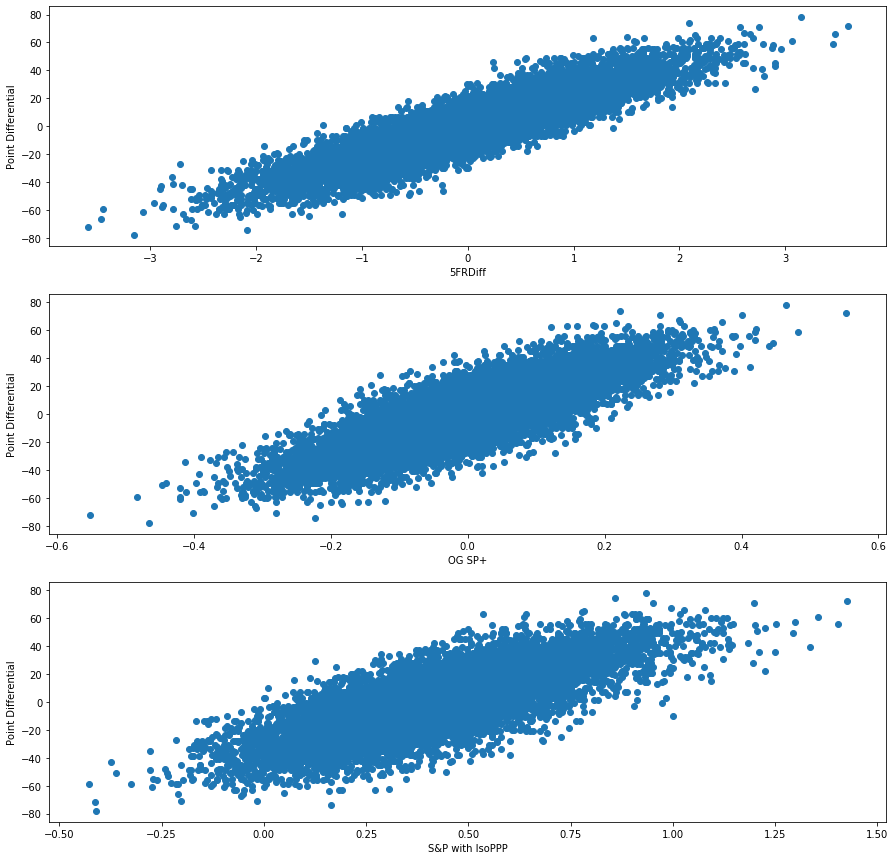

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912025,0.758809
S&PIsoPPPDiff,0.912025,1.000000,0.815979
PtsDiff,0.758809,0.815979,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0,-0.122680,-4.387538,-0.04152,-0.006633,0.012898,4.563898,-0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,SackRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0,0.122680,4.387538,0.04152,0.006633,-0.012898,5.436102,0.883089,0.995695,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0,0.017305,2.138834,-0.42232,0.042920,0.006561,5.208914,0.404725,0.456332,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0,-0.017305,-2.138834,0.42232,-0.042920,-0.006561,4.791086,-0.404725,0.456332,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0,0.087917,-6.578618,0.26167,0.059391,-0.004509,4.731171,-0.539235,0.607995,0.499553
5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,0,-0.087917,6.578618,-0.26167,-0.059391,0.004509,5.268829,0.539235,0.607995,0.499553


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [21]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.40662x + 0.02355
Mean Pred Score: -0.46596762715488066
Pred Std Dev: 19.505019359829642
Mean Abs Error: 7.471836731233202
Mdn Abs Error: 6.215417324478626
R-squared: 0.8045798550951692



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.766821,0.551516,0.471014,0.792578,0.616209,0.609894,0.981659,0.530248,0.762694,-0.448014,-0.437558,0.716037,0.744999,0.201404,0.519521,0.890073,0.897047,0.897047
OffSRDiff,0.766821,1.000000,0.481410,0.277475,0.702296,0.413244,0.453572,0.760873,0.751812,0.719792,-0.297229,-0.141831,0.652435,0.760345,-0.073518,0.529647,0.856125,0.892893,0.892893
OffERDiff,0.551516,0.481410,1.000000,0.128667,0.487618,0.289823,0.335389,0.539821,0.366211,0.801633,-0.171078,-0.085241,0.759896,0.613635,0.550517,0.166871,0.482775,0.501661,0.501661
FPDiff,0.471014,0.277475,0.128667,1.000000,0.587088,0.095636,0.072331,0.446695,0.040939,0.204486,-0.260974,-0.355028,0.206809,0.199734,0.011783,0.223863,0.566918,0.559896,0.559896
OppRateDiff,0.792578,0.702296,0.487618,0.587088,1.000000,0.229901,0.213417,0.789157,0.287112,0.665465,-0.293249,-0.273604,0.596276,0.741368,0.115655,0.484269,0.798194,0.815427,0.815427
OppEffDiff,0.616209,0.413244,0.289823,0.095636,0.229901,1.000000,0.746183,0.614994,0.501943,0.429316,-0.322712,-0.337125,0.403949,0.369473,0.141872,0.317843,0.515616,0.511613,0.511613
OppPPDDiff,0.609894,0.453572,0.335389,0.072331,0.213417,0.746183,1.000000,0.614528,0.550484,0.469922,-0.342553,-0.328569,0.456604,0.379919,0.176875,0.351102,0.568167,0.568367,0.568367
PPDDiff,0.981659,0.760873,0.539821,0.446695,0.789157,0.614994,0.614528,1.000000,0.524653,0.751586,-0.432988,-0.427540,0.705409,0.720360,0.194235,0.521475,0.879734,0.886718,0.886718
OppSRDiff,0.530248,0.751812,0.366211,0.040939,0.287112,0.501943,0.550484,0.524653,1.000000,0.535161,-0.245665,-0.101109,0.494861,0.459222,-0.043396,0.345993,0.620535,0.647900,0.647900
YPPDiff,0.762694,0.719792,0.801633,0.204486,0.665465,0.429316,0.469922,0.751586,0.535161,1.000000,-0.305695,-0.166651,0.921694,0.797481,0.508928,0.415599,0.702511,0.728001,0.728001


In [68]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.748450,0.766821,0.716037,0.903701,0.471014,0.299232,0.890073,0.897047,0.897047
ActPts,0.748450,1.000000,0.584481,0.547525,0.676014,0.328729,0.219535,0.665853,0.671511,0.671511
Eff,0.766821,0.584481,1.000000,0.652435,0.812761,0.277475,0.029098,0.856125,0.892893,0.892893
Expl,0.716037,0.547525,0.652435,1.000000,0.698328,0.206809,0.057628,0.657194,0.679897,0.679897
FinDrv,0.903701,0.676014,0.812761,0.698328,1.000000,0.397843,0.226403,0.903584,0.919603,0.919603
FldPos,0.471014,0.328729,0.277475,0.206809,0.397843,1.000000,0.288591,0.566918,0.559896,0.559896
Trnovr,0.299232,0.219535,0.029098,0.057628,0.226403,0.288591,1.000000,0.453293,0.360717,0.360717
5FR,0.890073,0.665853,0.856125,0.657194,0.903584,0.566918,0.453293,1.000000,0.994847,0.994847
5FRDiff,0.897047,0.671511,0.892893,0.679897,0.919603,0.559896,0.360717,0.994847,1.000000,1.000000
PredPtsDiff,0.897047,0.671511,0.892893,0.679897,0.919603,0.559896,0.360717,0.994847,1.000000,1.000000


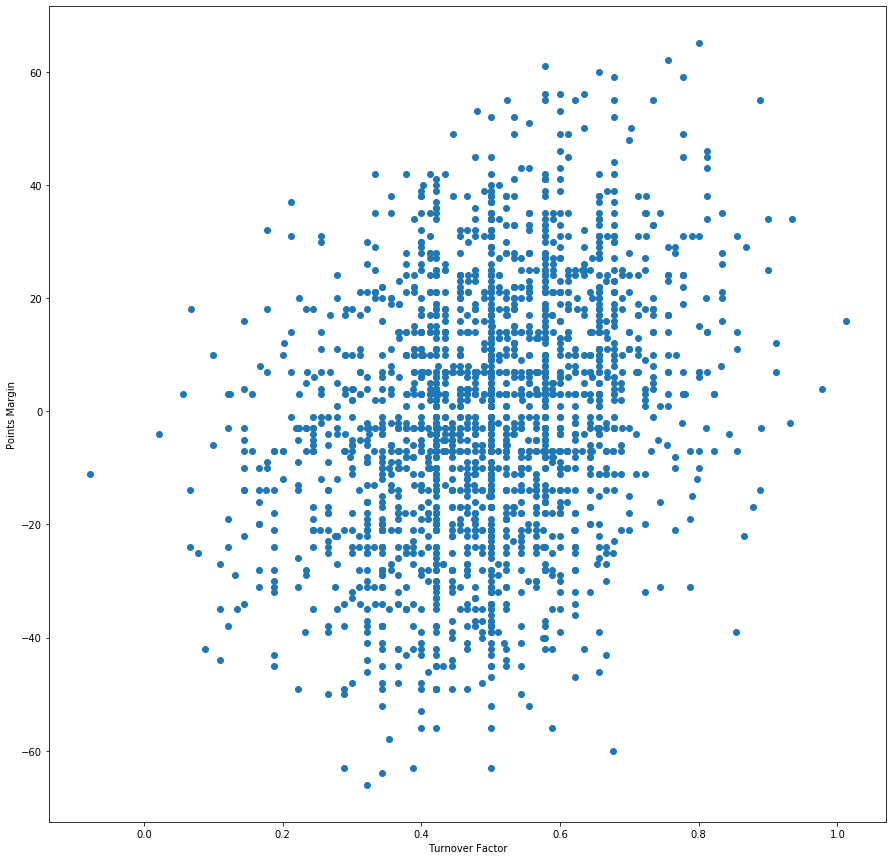

In [72]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

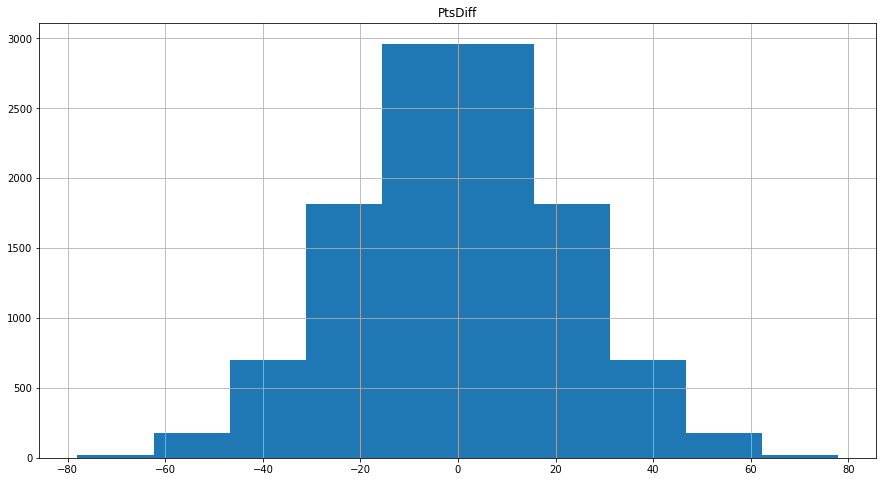

In [22]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

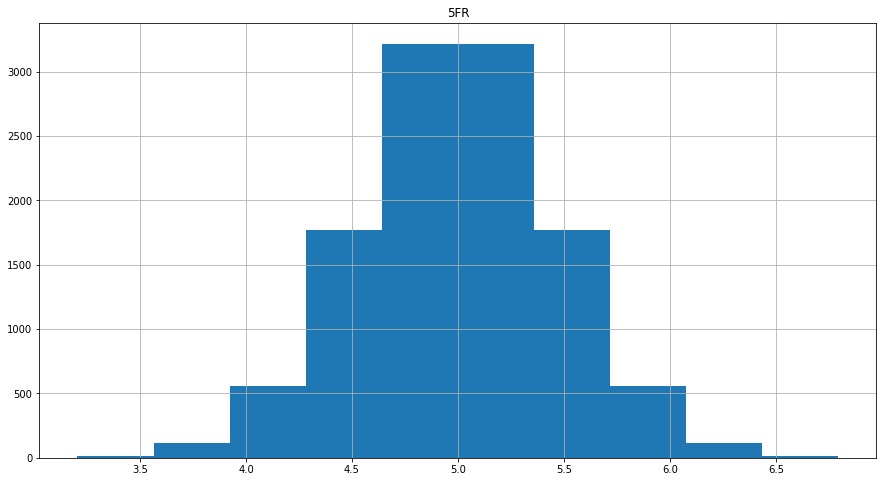

In [23]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

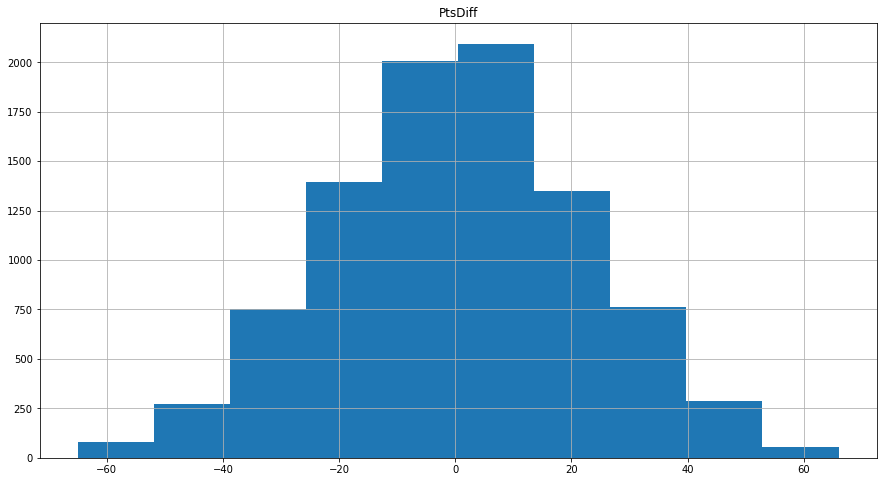

In [24]:
train_data.hist(column='PtsDiff', figsize=(15,8));

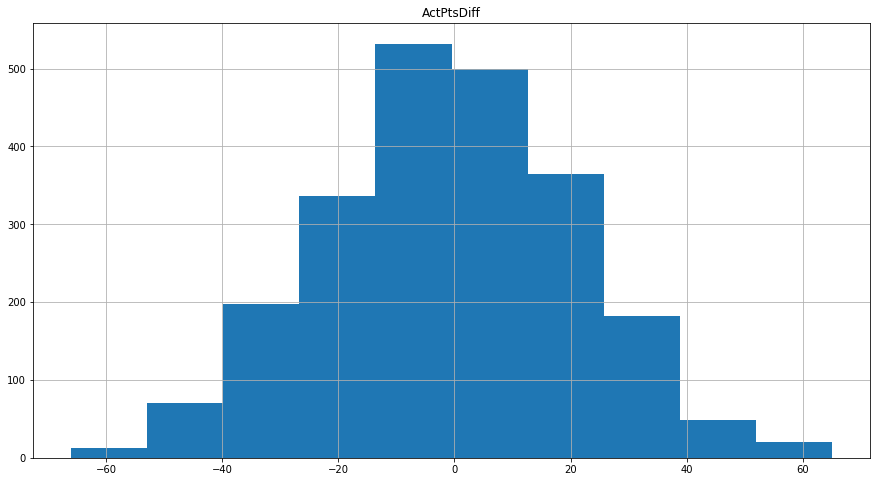

In [25]:
test.hist(column='ActPtsDiff', figsize=(15,8));

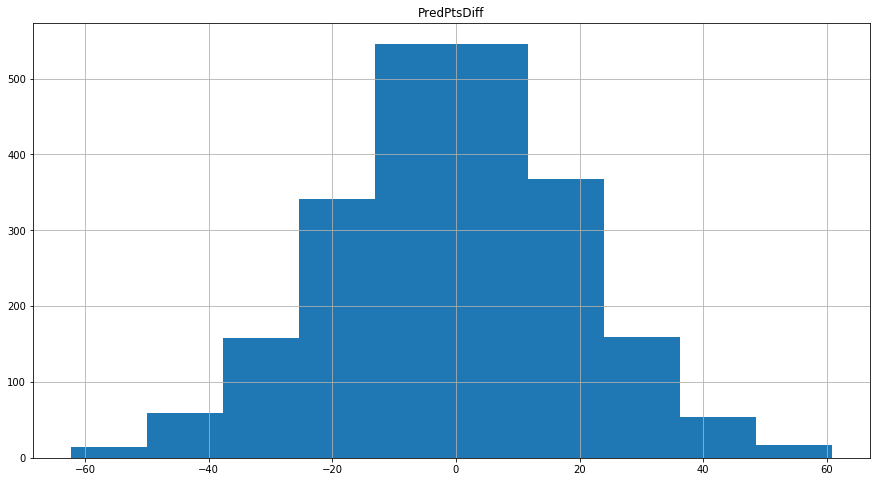

In [26]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [27]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [28]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -5.0 (exact value: -4.584921788709051)
Z score: -0.21117406168983907
Win Prob for Virginia Tech: 41.64%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [29]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -17.0 (exact value: -16.53720407581376)
Z score: -0.8239538834684472
Win Prob for Georgia Tech: 20.50%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [30]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -7.0 (exact value: -6.701634357728263)
Z score: -0.3196954904549167
Win Prob for Georgia Tech: 37.46%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [31]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.925442172998976)
Z score: 0.3276802592319847
Win Prob for Mississippi State: 62.84%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [32]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -8.348576848454096)
Z score: -0.4041323454173727
Win Prob for Texas A&M: 34.31%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [33]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.945146,13,12.0,1.0
2,Clemson,0.938772,13,12.0,1.0
3,Alabama,0.922749,12,11.0,1.0
4,LSU,0.916597,13,12.0,1.0
5,Wisconsin,0.866827,13,11.0,2.0
6,Utah,0.840648,13,11.0,2.0
7,Oregon,0.824458,13,11.0,2.0
8,Oklahoma,0.823237,13,11.0,2.0
9,Appalachian State,0.810002,13,11.0,2.0
10,Notre Dame,0.800172,12,10.0,2.0


In [34]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.476415,1.523585
21,Clemson,10.617055,2.382945
53,LSU,10.473079,2.526921
128,Wisconsin,9.505104,3.494896
2,Alabama,9.374859,2.625141
115,Utah,9.214039,3.785961
78,Oklahoma,8.967379,4.032621
3,Appalachian State,8.921192,4.078808
82,Oregon,8.814125,4.185875
56,Memphis,8.616755,4.383245


In [35]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1
1,Florida State,2012,5.456845,2
2,Fresno State,2012,5.371180,3
3,Arizona State,2012,5.339381,4
4,Oklahoma,2012,5.339329,5
5,Notre Dame,2012,5.326277,6
6,Georgia,2012,5.306892,7
7,BYU,2012,5.306499,8
8,Kansas State,2012,5.302395,9
9,Ohio State,2012,5.285753,10


In [36]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for idx, item in enumerate(team_games, start=1):
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [37]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
        
#     print(grouped_by_year.get_group((team1, year))[:1].tail(4))
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019,0)

[0.047604002851335175, -33.01092894329362]

In [63]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 ML / 5-5 ATS ------
    ['Miami','Louisiana Tech',6],
    ['Pittsburgh','Eastern Michigan',11],
    ['North Carolina','Temple',5],
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Notre Dame', 'Iowa State', 4],
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Florida','Virginia',14], # Orange Bowl
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Miami,Louisiana Tech,6.0,9.877297,0.702044,True,Miami,Miami
0,Pittsburgh,Eastern Michigan,11.0,3.038661,0.571297,False,Pittsburgh,Eastern Michigan
0,North Carolina,Temple,5.0,-2.189960,0.464785,False,Temple,Temple
0,Michigan State,Wake Forest,3.5,14.713633,0.781786,True,Michigan State,Michigan State
0,Texas A&M,Oklahoma State,7.0,1.339098,0.536867,False,Texas A&M,Oklahoma State
0,Iowa,USC,2.5,3.488488,0.580331,True,Iowa,Iowa
0,Air Force,Washington State,3.0,2.247947,0.555330,False,Air Force,Washington State
0,Penn State,Memphis,7.0,-0.197272,0.505496,False,Memphis,Memphis
0,Notre Dame,Iowa State,4.0,8.468713,0.676549,True,Notre Dame,Notre Dame
0,LSU,Oklahoma,11.0,10.576067,0.714341,False,LSU,Oklahoma


In [39]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 7.0 (exact value: 6.53522349125333)
Z score: 0.3589430489275536
Win Prob for Virginia: 64.02%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [40]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.575043146546117)
Z score: 0.6685976841714295
Win Prob for North Carolina: 74.81%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [41]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 15.0 (exact value: 15.153604677615785)
Z score: 0.8007975801828215
Win Prob for Pittsburgh: 78.84%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [42]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -8.180187932888494)
Z score: -0.3954992386021907
Win Prob for Auburn: 34.62%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [43]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 27.0 (exact value: 27.26314332695373)
Z score: 1.421639755519361
Win Prob for Georgia: 92.24%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [64]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 21.0 (exact value: 20.502720750406098)
Z score: 1.0750406339378338
Win Prob for Clemson: 85.88%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 5.0 (exact value: 4.70269636940528)
Z score: 0.2649914825106487
Win Prob for Georgia Tech: 60.45%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -14.0 (exact value: -13.58728228327907)
Z score: -0.6727147722369035
Win Prob for The Citadel: 25.06%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 27.0 (exact value: 26.98492739569216)
Z score: 1.4073759434139212
Win Prob for Temple: 92.03%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 13.0 (exact value: 12.575043146546117)
Z score: 0.668597684171429

,GameID,Year,Team,Opponent,PredWinProb,PredMOV,ActualMOV,PostGameWinProb
0,401111653,2019,Georgia Tech,Clemson,18.612759,-16.937523,-38.0,14.117827
1,401112441,2019,Georgia Tech,South Florida,81.967119,17.363818,4.0,60.449199
2,401112452,2019,Georgia Tech,The Citadel,97.852043,39.014279,-3.0,74.943562
3,401112469,2019,Georgia Tech,Temple,44.727858,-2.119228,-22.0,7.965797
4,401112475,2019,Georgia Tech,North Carolina,52.151755,0.586576,-16.0,25.187608
5,401112480,2019,Georgia Tech,Duke,22.863921,-14.032811,-18.0,25.638519
6,401112488,2019,Georgia Tech,Miami,36.070582,-6.488992,7.0,20.498288
7,401112498,2019,Georgia Tech,Pittsburgh,38.208865,-6.317470,-10.0,21.162442
8,401112504,2019,Georgia Tech,Virginia,33.164008,-8.026302,-5.0,17.951468
9,401112511,2019,Georgia Tech,Virginia Tech,13.411343,-22.061050,-45.0,0.079370


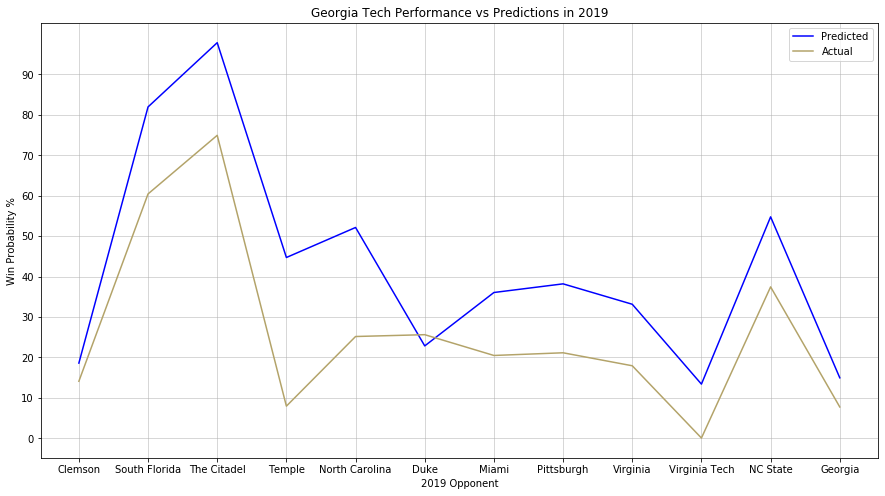

In [66]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

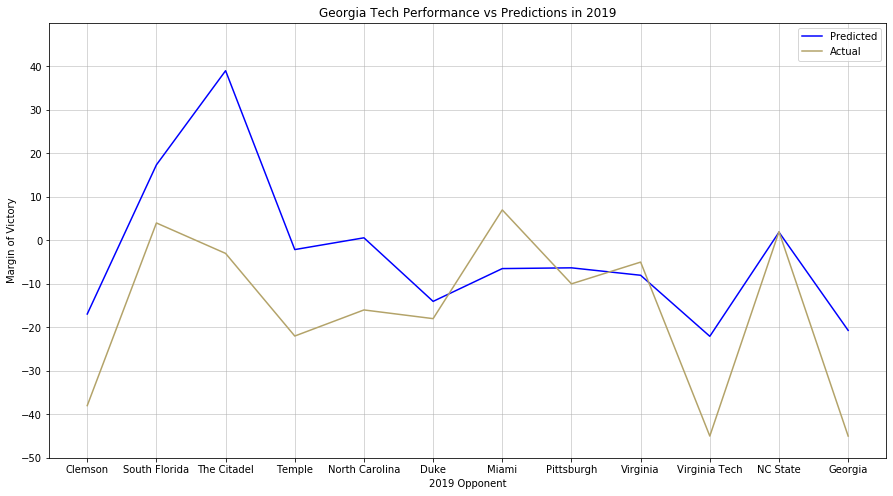

In [67]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 36.0 (exact value: 36.47124527235025)
Z score: 1.893728594577911
Win Prob for Georgia Tech: 97.09%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 13.0 (exact value: 13.453315762690346)
Z score: 0.7136257151588287
Win Prob for South Florida: 76.23%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 11.0 (exact value: 11.05227343717246)
Z score: 0.5905270254716599
Win Prob for Pittsburgh: 72.26%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 31.0 (exact value: 30.620366680842253)
Z score: 1.5937607512463727
Win Prob for Clemson: 94.45%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 40.0 (exact value: 39.85928491201343)
Z sco

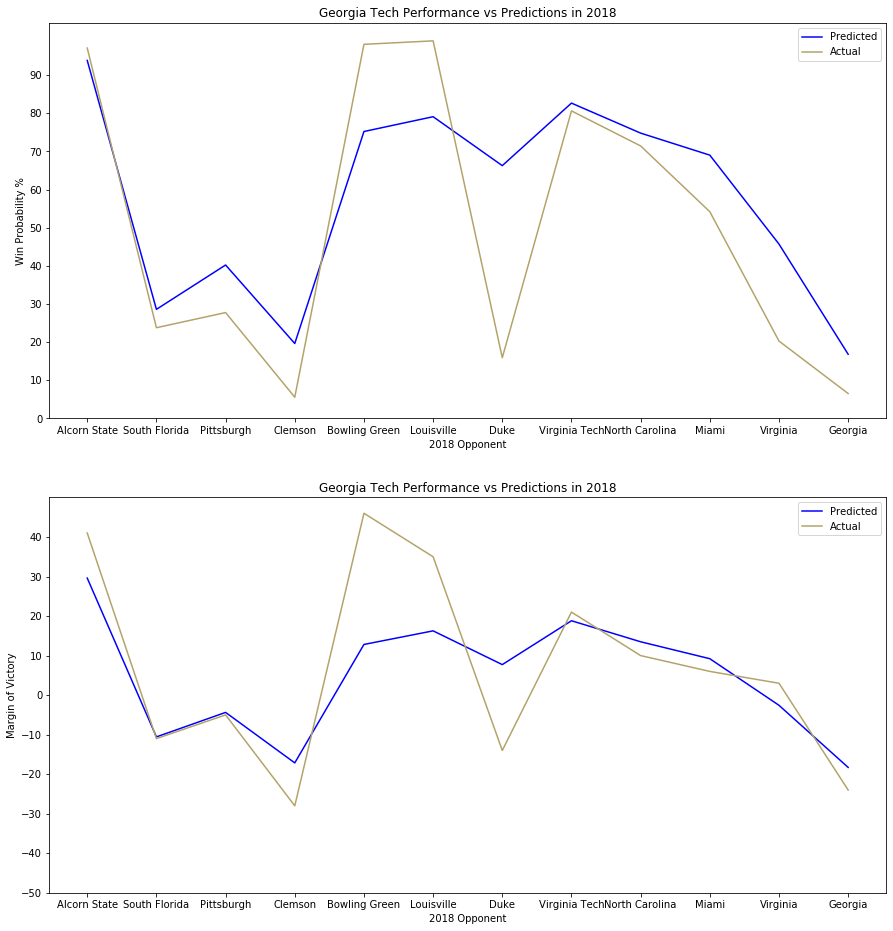

In [47]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

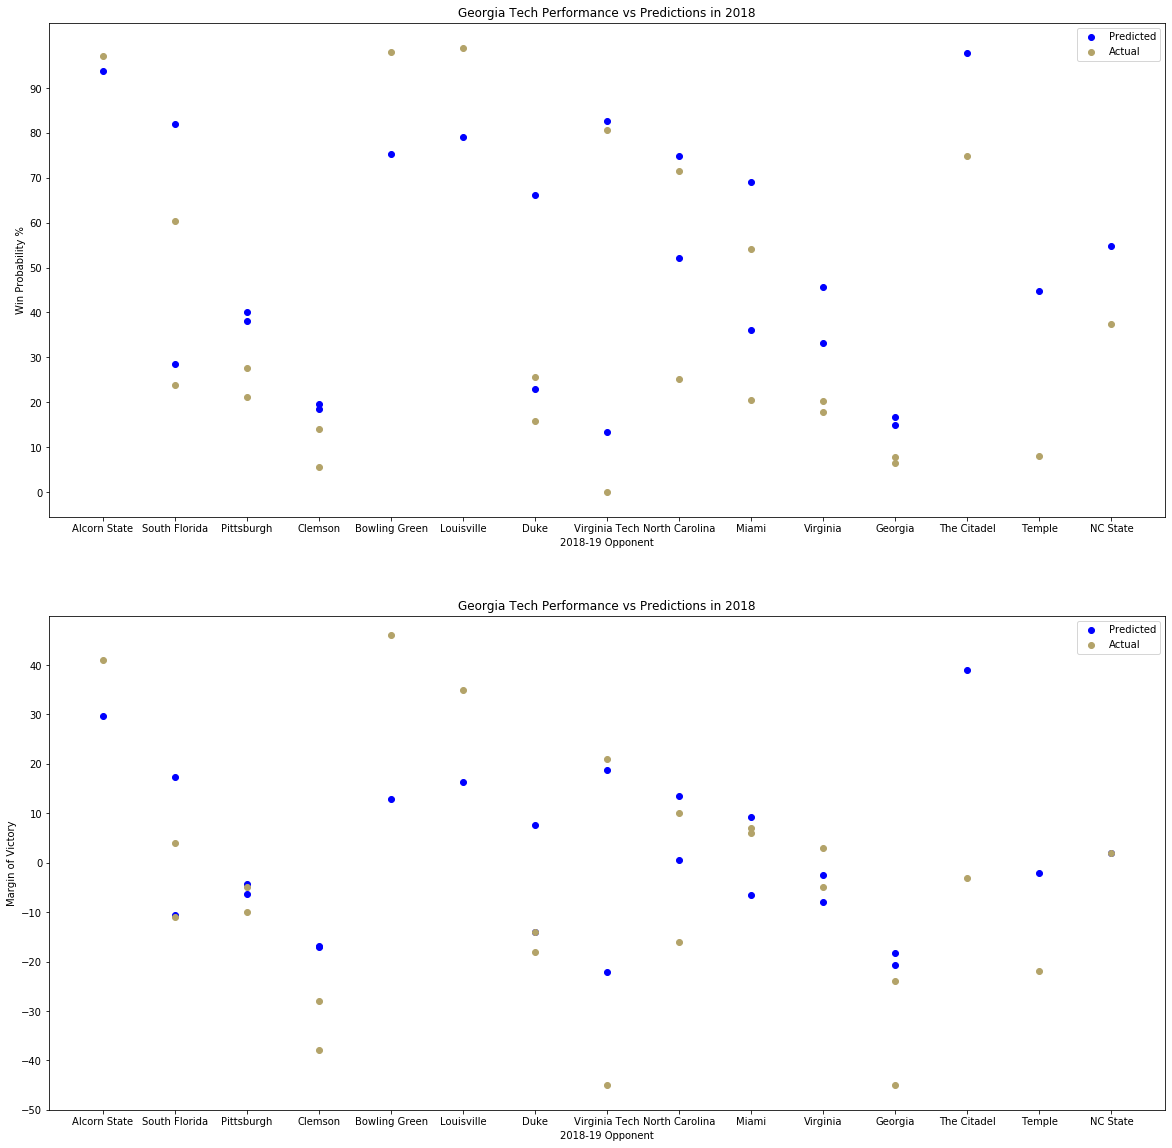

In [75]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [181]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.581310,0.523315,0.435028,0.365191,0.286904,0.285329,0.383764
2013,0.581310,1.000000,0.555835,0.369550,0.250899,0.232639,0.179753,0.281026
2014,0.523315,0.555835,1.000000,0.559955,0.460823,0.287926,0.281157,0.359910
2015,0.435028,0.369550,0.559955,1.000000,0.642715,0.446838,0.345127,0.368099
2016,0.365191,0.250899,0.460823,0.642715,1.000000,0.567064,0.409997,0.581482
2017,0.286904,0.232639,0.287926,0.446838,0.567064,1.000000,0.602075,0.539130
2018,0.285329,0.179753,0.281157,0.345127,0.409997,0.602075,1.000000,0.583893
2019,0.383764,0.281026,0.359910,0.368099,0.581482,0.539130,0.583893,1.000000


In [79]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent,row.Year - 1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team,row.Opponent, row.Year - 1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["Gardner-Webb","UCF","Duke","Miami","Virginia","North Carolina","Pittsburgh","Syracuse","Virginia Tech","Clemson","Notre Dame","Georgia"],
    "Site" : ["Home","Home","Home","Home","Home","Away","Away","Away","Away","Home","Neutral","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,Georgia Tech,Gardner-Webb,Home,92.902622,28.178655
1,2020,Georgia Tech,UCF,Home,21.716469,-15.715083
2,2020,Georgia Tech,Duke,Home,40.955988,-4.926322
3,2020,Georgia Tech,Miami,Home,18.530443,-17.929464
4,2020,Georgia Tech,Virginia,Home,22.669494,-15.090355
5,2020,Georgia Tech,North Carolina,Away,27.954776,-11.860517
6,2020,Georgia Tech,Pittsburgh,Away,29.559855,-10.942154
7,2020,Georgia Tech,Syracuse,Away,24.586626,-13.876758
8,2020,Georgia Tech,Virginia Tech,Away,10.649137,-24.757626
9,2020,Georgia Tech,Clemson,Home,4.760400,-33.010929


In [48]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)